<a href="dse_cfbe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Warmup

Inside the folder **apps** there are the source code for generating the application to run duringa the DSE (Design Space Exploration). It's required to get inside the folder and run **make** to compile the application. The whole folder estructure is:

```
algo1
|-- algo1
|-- JSON file
|-- Makefile
|-- algo1.py
|-- testing.in
|-- training.in
|-- _src_
|-- _build_
templates (_for Vitis_)
|-- Makefile
|-- source code
```

In [1]:
#application = 'algo1'
application = 'algo2'
#application = 'fir'
#application = 'sobel'
#application = 'lowpass'
#application = 'highpass'
#application = 'smooth'
#application = 'gaussian'

## 1.1  Libraries

In [2]:
import numpy as np
from mealpy.evolutionary_based import GA
import csv
import pandas as pd 
import networkx as nx
import collections
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import scipy.stats as ss
import evoapproxlib as eal
import time 
import math
from PIL import Image
import os
import random
from itertools import product
import re
import argparse
import seaborn as sns
import json
from datetime import datetime
import ast

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4
rcParams['font.size'] = 13
rcParams['figure.dpi'] = 300

## 1.2. Auxiliary functions

In [4]:
'''
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
'''
def pareto_frontier(Xs, Ys, maxX = True, maxY = True, start=0, final=172):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(start, final)], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

In [5]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [6]:
def get_physicmetric_mul(name):
    for i in range(len(NAME_MUL)):
        if name == 'mul16s_' + NAME_MUL[i]:
            return PAP_MUL[i]
        
def get_physicmetric_add(name):
    for i in range(len(NAME_ADD)):
        if name == 'add16se_' + NAME_ADD[i]:
            return PAP_ADD[i]

def get_pos_mul(name):
    for i in range(len(NAME_MUL)):
        if name == 'mul16s_' + NAME_MUL[i]:
            return i

def get_pos_add(name):
    for i in range(len(NAME_ADD)):
        if name == 'add16se_' + NAME_ADD[i]:
            return i

In [7]:
def generate_comp():
    randcomp = []
    for i in range(dict_app['totalcomp']):
        if i < dict_app['totalmul']:
            randcomp.append(random.randint(0,7))
        else:
            randcomp.append(random.randint(0,11))
    
    return randcomp

In [8]:
def init_design_space():
    path = dict_app['name']

    if not os.path.exists(path):
        os.mkdir(path)

    if not os.path.exists(path + '/src'):
        os.mkdir(path + '/src')

    os.popen('cp apps/templates/template_' + dict_app['name'] + '.cpp ' + path + '/src/' + dict_app['name'] + '.cpp')
    os.popen('cp apps/templates/Makefile ' + path + '/Makefile')
    time.sleep(2)

    make = open(path + "/Makefile", "r")
    model = make.read()
    model = model.replace("\"template\"", dict_app['name'])
    make.close()
    make = open(path + "/Makefile", "wt")
    make.write(model)
    make.close()

In [9]:
def plot_error_dist(x, approx, log=True, nameplot="plot.png"):
    if log == True:
        plt.yscale('log')
        plt.xscale('log')
    #patterns = ["o","v","^","<",">",".",",","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    patterns = ['-','--','-.',':','.',',','o','v','^','<','>','1','2','3','4','s','p','*','h','H','+','x','D','d','|','_']
    i = 0
    for values, name in approx:
        #plt.plot(x, values, marker=patterns[i], label=name)
        plt.plot(x, values, linestyle=patterns[i], label=name)
        i += 1
    plt.xlabel(r'$\delta_i$')
    plt.ylabel(r'Error$_{total}$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(approx), fancybox=True)
    plt.savefig(nameplot, bbox_inches = 'tight')

# 2. Application

## 2.1. Dictionary of the application

In [10]:
jsonfile = 'apps/' + application + '/' + application + '.json'

with open(jsonfile) as json_file:
    dict_app = json.load(json_file)

    exec(dict_app['source'])

    dict_app['func'] = eval(dict_app['func'])
    dict_app['image'] = eval(dict_app['image'])
    dict_app['allds'][0] = eval(dict_app['allds'][0])
    
dict_app

{'name': 'algo2',
 'source': 'from apps.algo2.algo2 import*',
 'func': <function apps.algo2.algo2.algo(params, inputfile)>,
 'metricerror': 'MAE',
 'maxerror': 2700,
 'metricphysic': 'LUT+FF',
 'totalmul': 1,
 'totaladd': 2,
 'totalcomp': 3,
 'error': [],
 'popsize': 50,
 'runs': 10,
 'epochs': 100,
 'crossover': 0.85,
 'mutation': 0.3,
 'dse_step': 0.05,
 'image': False,
 'alpha': 0.3,
 'allds': [True, 300],
 'training': 'training.in',
 'testing': 'testing.in',
 'iterations': 80,
 'plotextension': '.pdf'}

## 2.2. Dictionary of DFGs

In [11]:
dfg_case = {
    'algo1': ['DFGs/edges.csv', 'DFGs/nodes.csv'],
    'algo2': ['DFGs/edges2.csv', 'DFGs/nodes2.csv'],
    'sobel': ['DFGs/edges-sobelgx.csv', 'DFGs/nodes-sobelgx.csv'],
    'highpass': ['DFGs/edges-highpass.csv', 'DFGs/nodes-highpass.csv'],
    'lowpass': ['DFGs/edges-lowpass.csv', 'DFGs/nodes-lowpass.csv'],
    'smooth': ['DFGs/edges-smooth.csv', 'DFGs/nodes-smooth.csv'],
    'fir': ['DFGs/edges-fir.csv', 'DFGs/nodes-fir.csv'],
    'fft': ['DFGs/edges-fft1.csv', 'DFGs/nodes-fft1.csv'],
    'cos': ['DFGs/edges-cos.csv', 'DFGs/nodes-cos.csv'],
    'idct': ['DFGs/edges-idct.csv', 'DFGs/nodes-idct.csv'],
    'gaussian': ['DFGs/edges-gaussian.csv', 'DFGs/nodes-gaussian.csv']
}

dfg_name = dict_app['name']

## 2.3. Here is just for displaing the DFG

Here is made a read from a CSV file with a networkx that represent a DFG from the application. There are two separate CSVs, one for nodes, and another for the edges. The most important is the CSV for the nodes. The CSV for the nodes is:


| Node | Name             | Operation           | Error      | Status            | PAP                | $$\delta$$    | (pos)*         | Color                                       | Component Index              |
|------|------------------|---------------------|------------|-------------------|--------------------|---------------|----------------|---------------------------------------------|------------------------------|
| ID   | Some string name | in, out, *, +, -, / | Node error | left, right arrow | Power-Area Product | Approximation | Can't remember | green for input/ouput, yellow for operation | Index in the solution vector |

After that, flowing the equations in the Ansaloni paper:

$$
E_{t} = \sum_{n_i \in G} e_i = \sum_{n_i \in G} \left( \delta_i \times \sum_{p \in P} \left( \prod_{n_j \in succ(n_i)} v(n_j) \right) \right)
$$

Besides the rules for finding $k_1$ and $k_2$ or the wights for the vertices.


|    Op.     |          $$v_{left}$$         |                  $$v_{right}$$                   |
|------------|-------------------------------|--------------------------------------------------|
|    +/-     |              1                |                       1                          |
| $$\times$$ |  $$max(|input_{right}|)$$ |           $$max(|input_{left}|)$$            |
|  $$\div$$  | $$max(|1/input_{left}|)$$ | $$max\left(\left|\frac{input_{left}}{input_{right}^2}\right|\right)$$ |

/tmp/ipykernel_2843/3284482994.py:10: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")
/tmp/ipykernel_2843/3284482994.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


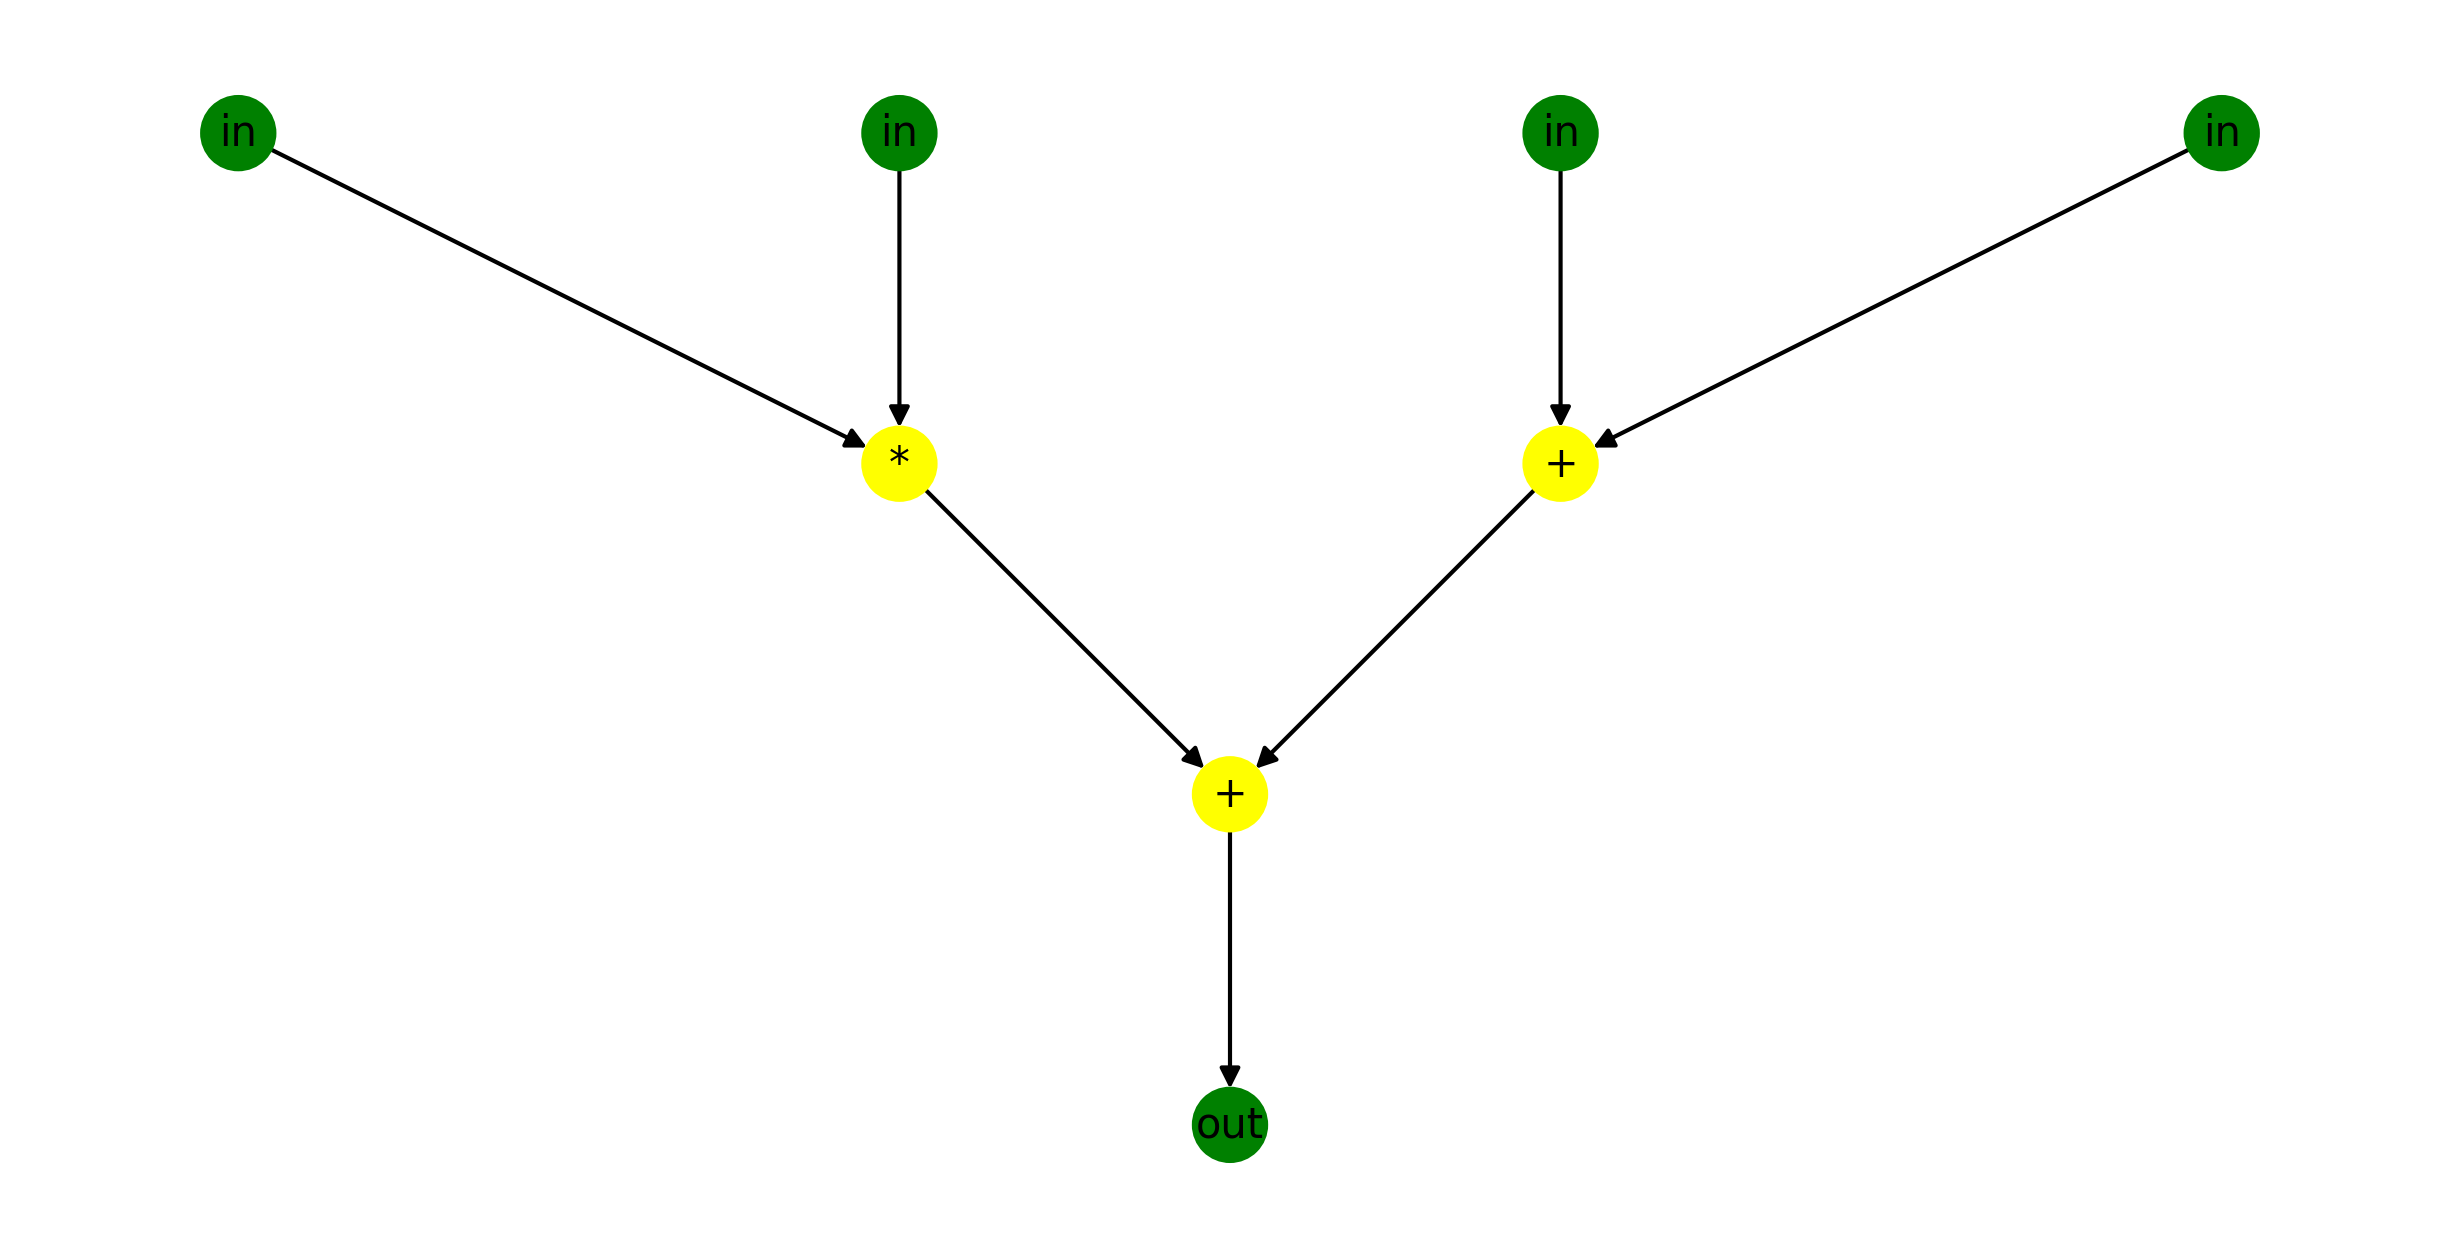

In [12]:
G= nx.DiGraph()

edges = pd.read_csv(dfg_case[dfg_name][0])
G = nx.from_pandas_edgelist(edges, 'node1', 'node2', create_using=nx.DiGraph())

nodes = pd.read_csv(dfg_case[dfg_name][1])
data = nodes.set_index('node').to_dict('index').items()
G.add_nodes_from(data)

pos = graphviz_layout(G, prog="dot")
labels = nx.get_node_attributes(G, 'op')
colors = [G.nodes[node]['color'] for node in G]     
nx.draw(G, pos=pos, node_color=colors, labels=labels, node_size=300, with_labels = True, font_size=10)
plt.tight_layout()
plt.savefig('logs/' + dfg_name + dict_app['plotextension'], bbox_inches = 'tight')
plt.show()

## 2.2. Load features of the components

In [13]:
comp = pd.read_csv("apps/components_rev.csv")

NAME_MUL = comp['Name'].head(8).values
ERROR_MUL = comp[dict_app['metricerror']].head(8).values
PAP_MUL = comp[dict_app['metricphysic']].head(8).values
NAME_ADD = comp['Name'].tail(12).values
ERROR_ADD = comp[dict_app['metricerror']].tail(12).values
PAP_ADD = comp[dict_app['metricphysic']].tail(12).values

PAP_ADD

array([162, 120, 116, 149, 116, 172, 138, 128, 140, 158, 158, 141])

# 4. Design space exploration

In [14]:
def calcpoint(pparams_dict, designs):
    
    if dict_app['image'] == True:
        keys = ['PSNR', 'SSIM', 'MSE']
        baseline(pparams_dict, dict_app)
    else:
        keys = ['MAE', 'WCE', 'MRED', 'MSE', 'EP', 'PROB', 'KEYS', 'BIAS', 'HD']    
    
    aparams_dict = pparams_dict.copy()
    aparams_dict['kind'] = 'approx'
    
    muls = list(eal.multipliers['16x16_signed'].items())
    adds = list(eal.adders['16_signed_extended'].items())

    area = [None] * len(designs)
    error = [None] * len(designs)

    for i in range(len(designs)):
        allarea = 0
        for j in range(dict_app['totalmul']):
            allarea += get_physicmetric_mul(muls[designs[i][j]][0])
            aparams_dict['m' + str(j)] = designs[i][j]
        for j in range(dict_app['totaladd']):
            allarea += get_physicmetric_add(adds[designs[i][j + dict_app['totalmul']]][0])
            aparams_dict['a' + str(j)] = designs[i][j + dict_app['totalmul']]
            
        print(f'Executing design point #{i} from {aparams_dict}')

        values = list(compute_error(dict_app['func'](pparams_dict, dict_app['training']), 
                                    dict_app['func'](aparams_dict, dict_app['training'])))

        metric_pairs = zip(keys, values)
        metric_dict = dict(metric_pairs)

        area[i] = allarea
        error[i] = metric_dict[dict_app['metricerror']]
        
    return area, error

In [15]:
def savepoints(file, solution):
    comp = pd.read_csv("apps/components_rev.csv")

    NAME_MUL = comp['Name'].head(8).values
    PAP_MUL = comp[dict_app['metricphysic']].head(8).values
    NAME_ADD = comp['Name'].tail(12).values
    PAP_ADD = comp[dict_app['metricphysic']].tail(12).values
    
    func = []
    val = []

    for i in range(dict_app['totalmul']):
        func.append('m' + str(i))
        val.append(0)

    for i in range(dict_app['totaladd']):
        func.append('a' + str(i))
        val.append(0)

    params = zip(func, val)
    pparams_dict = dict(params)
    pparams_dict['kind'] = 'precise'

    area, error = calcpoint(pparams_dict, solution)

    c = open(file, 'wt', encoding='UTF8')

    writer = csv.writer(c)
    header = ['components', 'area', 'error']
    writer.writerow(header)
    rows = zip(solution, area, error)

    for row in rows:
        writer.writerow(row)
    c.close() 

## 4.1. Fitness function DFG

### 4.1.1. Ansaloni

In [16]:
def fitness_function(solution):
    
    G = nx.DiGraph()

    edges = pd.read_csv(dfg_case[dfg_name][0])
    G = nx.from_pandas_edgelist(edges, 'node1', 'node2', create_using=nx.DiGraph())

    nodes = pd.read_csv(dfg_case[dfg_name][1])
    data = nodes.set_index('node').to_dict('index').items()
    G.add_nodes_from(data)
    
    solution_int = np.trunc(solution).astype(int)                 # Convert float to integer here
    
    mul = 0
    add = dict_app['totalmul']
    for node in G.nodes():
        if G.nodes[node]['op'] == '*':
            G.nodes[node]['d'] = ERROR_MUL[solution_int[mul]]
            G.nodes[node]['pap'] = PAP_MUL[solution_int[mul]]
            G.nodes[node]['pos'] = solution_int[mul]
            mul += 1
        if G.nodes[node]['op'] == '+':
            G.nodes[node]['d'] = ERROR_ADD[solution_int[add]]
            G.nodes[node]['pap'] = PAP_ADD[solution_int[add]]
            G.nodes[node]['pos'] = solution_int[add]
            add += 1
                
    #print(mul, add)
    C = G.copy()
    #def calc_error(G):
    for node in G.nodes():
        if (G.nodes[node]['op'] == 'in'):
            successors = list(nx.nodes(nx.dfs_tree(G, node)))
            (x1, x2) = G.in_edges([successors[1]])
            if G.nodes[successors[1]]['op'] == '*':
                G.nodes[successors[1]]['error'] = G.nodes[x1[0]]['error'] * G.nodes[x2[0]]['error'] + G.nodes[successors[1]]['d']
            elif G.nodes[successors[1]]['op'] == '+':
                G.nodes[successors[1]]['error'] = G.nodes[x1[0]]['error'] + G.nodes[x2[0]]['error'] + G.nodes[successors[1]]['d']
            #elif G.nodes[successors[1]]['op'] == '-':
            #    G.nodes[successors[1]]['error'] = G.nodes[x1[0]]['error'] - G.nodes[x2[0]]['error'] + G.nodes[successors[1]]['d']
            #elif G.nodes[successors[1]]['op'] == '/':
            #    G.nodes[successors[1]]['error'] = G.nodes[x1[0]]['error'] / G.nodes[x2[0]]['error'] + G.nodes[successors[1]]['d']
    
    for node in G.nodes():
        if (G.nodes[node]['op'] != 'in') and (G.nodes[node]['op'] != 'out'):
            successors = list(nx.nodes(nx.dfs_tree(G, node)))
            first = successors[0]
            successors.pop(0)
            error = G.nodes[first]['d']
            j = first
            for i in successors:
                if G.nodes[i]['op'] == '*':
                    (x1, x2) = G.in_edges([i])
                    if G.nodes[j]['status'] == 'l':
                        error *= G.nodes[x2[0]]['error']# + G.nodes[x2[0]]['d']
                    elif G.nodes[j]['status'] == 'r':
                        error *= G.nodes[x1[0]]['error']# + G.nodes[x2[0]]['d']
                if G.nodes[i]['op'] == '/':
                    (x1, x2) = G.in_edges([i])
                    if G.nodes[j]['status'] == 'l':
                        error *= 1 / G.nodes[x2[0]]['error']
                    elif G.nodes[j]['status'] == 'r':
                        error *=  G.nodes[x1[0]]['error'] / (G.nodes[x2[0]]['error'] ** 2)
                j = i
            C.nodes[first]['error'] = error
    
    G = C
    
    total_error = 0
    total_pap = 0
    for node in G.nodes():
        if (G.nodes[node]['op'] != 'in') and (G.nodes[node]['op'] != 'out'):
            total_error += G.nodes[node]['error']
            total_pap += G.nodes[node]['pap']
       

    #print(total_error)
    return [total_error, total_pap]

### 4.1.2. Normalize metrics (error and physic)

In [17]:
comp = pd.read_csv("apps/components_rev.csv")

NAME_MUL = comp['Name'].head(8).values
ERROR_MUL = comp[dict_app['metricerror']].head(8).values
PAP_MUL = comp[dict_app['metricphysic']].head(8).values
NAME_ADD = comp['Name'].tail(12).values
ERROR_ADD = comp[dict_app['metricerror']].tail(12).values
PAP_ADD = comp[dict_app['metricphysic']].tail(12).values

maximum = max(ERROR_MUL)
maximum *= dict_app['totalcomp']
for k in range(8):
    ERROR_MUL[k] /= maximum
    
maximum = max(ERROR_ADD)
maximum *= dict_app['totalcomp']
for k in range(12):
    ERROR_ADD[k] /= maximum

maximum = max(PAP_MUL)
maximum *= dict_app['totalcomp']
PAP_MUL = [float(i) for i in PAP_MUL]
for k in range(8):
    PAP_MUL[k] /= maximum
    
maximum = PAP_ADD[0]
maximum *= dict_app['totalcomp']
PAP_ADD = [float(i) for i in PAP_ADD]
for k in range(12):
    PAP_ADD[k] /= maximum
    
print(ERROR_MUL)
print(PAP_MUL)
print(ERROR_ADD)
print(PAP_ADD)

[0.         0.05619856 0.01587576 0.33333333 0.00881834 0.00529101
 0.03703704 0.00529117]
[0.3333333333333333, 0.1096752816434725, 0.16434724983432736, 0.07620941020543406, 0.24950298210735586, 0.1993041749502982, 0.1472829688535454, 0.1986414844267727]
[0.         0.06788428 0.14825241 0.31235822 0.15631644 0.04296744
 0.0208327  0.04720142 0.01660106 0.00520817 0.08373768 0.33333333]
[0.3333333333333333, 0.24691358024691357, 0.23868312757201646, 0.3065843621399177, 0.23868312757201646, 0.35390946502057613, 0.2839506172839506, 0.26337448559670784, 0.2880658436213992, 0.32510288065843623, 0.32510288065843623, 0.29012345679012347]


### 4.1.3. Run it

In [18]:
bestf = 999999999999999
bestp = []

LB = [None] * dict_app['totalcomp']
for k in range(dict_app['totalcomp']):
    LB[k] = 0
    
UB = [None] * dict_app['totalcomp']
for k in range(dict_app['totalcomp']):
    if k < dict_app['totalmul']:
        UB[k] = len(NAME_MUL)
    else:
        UB[k] = len(NAME_ADD)

##################################################################################################
fitness = []

header = ['case', 'metric', 'popsize', 'runs', 'epochs', 'solution', 'fitness', 'time (s)']

start_time = datetime.now()
with open('logs/OverallDSE_paper1.csv', 'a', encoding='UTF8') as fcsv:
    writer = csv.writer(fcsv)
    writer.writerow(header)

    for i in np.arange(0.7, .99, dict_app['dse_step']):

        errorpercent = round(i, 2)
        areapercent = round(1 - i, 2)
        file_log = 'logs/' + dict_app['name'] + "_result.log"

        problem_dict1 = {
            "fit_func": fitness_function,
            "lb": LB,
            "ub": UB,
            "minmax": "min",
            "log_to": "file",
            "log_file": file_log,
            "save_population": True,              # Default = False
            "obj_weights": [errorpercent, areapercent]
        }

        case = dict_app['name'] + '[' + str(errorpercent) + ',' + str(errorpercent) + ']'

        for j in range(dict_app['runs']):
            print(f"Run {j} -----------------------------------------------------------------------------") 
            model = GA.BaseGA(epoch=dict_app['epochs'], pop_size=dict_app['popsize'], pc=dict_app['crossover'], pm=dict_app['mutation'])
            start = time.time()
            best_position, best_fitness = model.solve(problem_dict1)
            stop = time.time()
            if (best_fitness < bestf):
                bestf = best_fitness
                bestp = best_position
                btime = stop - start


        data = [case, dict_app['metricerror'], dict_app['popsize'], dict_app['runs'], dict_app['epochs'], np.trunc(bestp).astype(int), bestf, btime]
        writer.writerow(data)

        print("Best solution: [", end="")
        for j in range(len(bestp)):
            if j < (len(bestp) - 1):
                print(f"{np.trunc(bestp[j]).astype(int)}, ", end="")
            else: 
                print(f"{np.trunc(bestp[j]).astype(int)}", end="")
        print(f"] - [{errorpercent}, {areapercent}]\n Best fitness: {bestf}")
        
        fitness.append(list(np.trunc(bestp).astype(int)))
        
    fcsv.close()
    
end_time = datetime.now()

f = open("logs/" + dict_app['name'] + "_DFG.time", "a")
f.write('Duration: {}\n'.format(end_time - start_time))
f.close()

Run 0 -----------------------------------------------------------------------------
Run 1 -----------------------------------------------------------------------------
Run 2 -----------------------------------------------------------------------------
Run 3 -----------------------------------------------------------------------------
Run 4 -----------------------------------------------------------------------------
Run 5 -----------------------------------------------------------------------------
Run 6 -----------------------------------------------------------------------------
Run 7 -----------------------------------------------------------------------------
Run 8 -----------------------------------------------------------------------------
Run 9 -----------------------------------------------------------------------------
Best solution: [2, 8, 8] - [0.7, 0.3]
 Best fitness: 0.25649819376159066
Run 0 -----------------------------------------------------------------------------
Run

In [19]:
path = dict_app['name']

comp = pd.read_csv("apps/components_rev.csv")

NAME_MUL = comp['Name'].head(8).values
ERROR_MUL = comp[dict_app['metricerror']].head(8).values
PAP_MUL = comp[dict_app['metricphysic']].head(8).values
NAME_ADD = comp['Name'].tail(12).values
ERROR_ADD = comp[dict_app['metricerror']].tail(12).values
PAP_ADD = comp[dict_app['metricphysic']].tail(12).values

if not os.path.exists(path):
    os.mkdir(path)
    
savepoints(path + '/dfg_points.csv', fitness)

Executing design point #0 from {'m0': 2, 'a0': 8, 'a1': 8, 'kind': 'approx'}
Executing design point #1 from {'m0': 2, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #2 from {'m0': 7, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #3 from {'m0': 7, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #4 from {'m0': 7, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #5 from {'m0': 7, 'a0': 0, 'a1': 0, 'kind': 'approx'}


## 4.3. Heuristic 2

Characterize error

In [20]:
def characterize(components, pparams_dict):
    
    if dict_app['image'] == True:
        keys = ['PSNR', 'SSIM', 'MSE']
        baseline(pparams_dict, dict_app)
    else:
        keys = ['MAE', 'WCE', 'MRED', 'MSE', 'EP', 'PROB', 'KEYS', 'BIAS', 'HD']    
    
    name = []
    
    for namem, m in eal.multipliers['16x16_signed'].items():  
        error = []
        for i in range(components['totalmul']):
            aparams_dict = pparams_dict.copy()
            aparams_dict['kind'] = 'approx'
            aparams_dict['m' + str(i)] = get_pos_mul(namem)   

            values = list(compute_error(dict_app['func'](pparams_dict, dict_app['training']), 
                                        dict_app['func'](aparams_dict, dict_app['training'])))
            
            metric_pairs = zip(keys, values)
            metric_dict = dict(metric_pairs)
            
            print(f"{dict_app['metricerror']} for component {namem} (position {i}) is {metric_dict[dict_app['metricerror']]}")
            
            if dict_app['metricerror'] == "SSIM":
                error.append(1 - metric_dict[dict_app['metricerror']])
            else:
                error.append(metric_dict[dict_app['metricerror']])
            
        name.append([namem, error])

    for namea, a in eal.adders['16_signed_extended'].items():
        error = []
        for i in range(components['totaladd']):
            aparams_dict = pparams_dict.copy()
            aparams_dict['kind'] = 'approx'
            aparams_dict['a' + str(i)] = get_pos_add(namea)

            values = list(compute_error(dict_app['func'](pparams_dict, dict_app['training']), 
                                        dict_app['func'](aparams_dict, dict_app['training'])))
            
            metric_pairs = zip(keys, values)
            metric_dict = dict(metric_pairs)
            
            print(f"{dict_app['metricerror']} for component {namea} (position {i}) is {metric_dict[dict_app['metricerror']]}")
            
            if dict_app['metricerror'] == "SSIM":
                error.append(1 - metric_dict[dict_app['metricerror']])
            else:
                error.append(metric_dict[dict_app['metricerror']])
            
        name.append([namea, error])

    return name

Run the calcutation of new errors

In [21]:
func = []
val = []

for i in range(dict_app['totalmul']):
    func.append('m' + str(i))
    val.append(0)

for i in range(dict_app['totaladd']):
    func.append('a' + str(i))
    val.append(0)
    
params = zip(func, val)
pparams_dict = dict(params)
pparams_dict['kind'] = 'precise'

start_time = datetime.now()
dict_app['error'] = characterize(dict_app, pparams_dict)
end_time = datetime.now()

f = open("logs/" + dict_app['name'] + "_recalc_error.time", "a")
f.write('Duration: {}\n'.format(end_time - start_time))
f.close()

path = dict_app['name']

if not os.path.exists(path):
    os.mkdir(path)

c = open(path  + '/components_error_' + dict_app['name'] + '.csv', 'wt', encoding='UTF8')

writer = csv.writer(c)
header = ['components', 'error']
writer.writerow(header)

for row in dict_app['error']:
    writer.writerow(row)
c.close() 

MAE for component mul16s_HEB (position 0) is 0.0
MAE for component mul16s_HFZ (position 0) is 610.986
MAE for component mul16s_GK2 (position 0) is 150.607
MAE for component mul16s_GAT (position 0) is 2682.027
MAE for component mul16s_HDG (position 0) is 89.524
MAE for component mul16s_G80 (position 0) is 45.09
MAE for component mul16s_G7F (position 0) is 312.017
MAE for component mul16s_G7Z (position 0) is 45.58
MAE for component add16se_RCA (position 0) is 0.0
MAE for component add16se_RCA (position 1) is 0.0
MAE for component add16se_2GE (position 0) is 6.47
MAE for component add16se_2GE (position 1) is 6.437
MAE for component add16se_25S (position 0) is 14.19
MAE for component add16se_25S (position 1) is 13.863
MAE for component add16se_2AS (position 0) is 29.779
MAE for component add16se_2AS (position 1) is 30.018
MAE for component add16se_2JB (position 0) is 14.498
MAE for component add16se_2JB (position 1) is 14.658
MAE for component add16se_294 (position 0) is 4.116
MAE for comp

In [22]:
def fitness_function(solution):
    
    solution_int = np.trunc(solution).astype(int)
    
    total_error = 0
    total_pap = 0

    mul = 0
    add = dict_app['totalmul']

    for i in range(dict_app['totalcomp']):
        if i < dict_app['totalmul']:
            total_error += ERROR_MUL[solution_int[i]][1][i]
            total_pap += PAP_MUL[solution_int[i]]
        else:
            total_error += ERROR_ADD[solution_int[i]][1][i - add]
            total_pap += PAP_ADD[solution_int[i]]
    
    return [total_error, total_pap]

Get the new error values

In [23]:
path = dict_app['name']

c = pd.read_csv(path  + '/components_error_' + dict_app['name'] + '.csv')

error = c['error'].tolist()
name = c['components'].tolist()

dict_app['error'] = []

for i in range(len(error)):
    values = list(re.split('\[|\]|,', error[i]))
    #print(values)
    floatvalue = []
    for j in range(1, len(values) - 1):
        #print(values[j])
        floatvalue.append(float(values[j]))
    error[i] = floatvalue
    
    dict_app['error'].append([name[i], error[i]])

#dict_app['error'] = [name, error]
dict_app['error']
ERROR_MUL = dict_app['error'][:8]
ERROR_ADD = dict_app['error'][8:20]

column(ERROR_MUL, 1)

[[0.0],
 [610.986],
 [150.607],
 [2682.027],
 [89.524],
 [45.09],
 [312.017],
 [45.58]]

Normalize que errors

In [24]:
ERROR_MUL = dict_app['error'][:8]
#ERROR_MUL = [None] * 8
ERROR_ADD = dict_app['error'][8:20]
#ERROR_ADD = [None] * 12

maxmul = max(column(ERROR_MUL, 1))
maxmul = max(maxmul)

maxadd = max(column(ERROR_ADD, 1))
maxadd = max(maxadd)

if maxmul > maxadd:
    maximum = maxmul
else:
    maximum = maxadd

for k in range(8):
    ERROR_MUL[k][1] = np.divide(ERROR_MUL[k][1], (maximum * dict_app['totalcomp']))

print(ERROR_MUL)
print()

for k in range(12):
    ERROR_ADD[k][1] = np.divide(ERROR_ADD[k][1], (maximum * dict_app['totalcomp']))
    
print(ERROR_ADD)
print()

maximum = PAP_MUL[0] 
PAP_MUL = [float(i) for i in PAP_MUL]
for k in range(8):
    PAP_MUL[k] /= (maximum * dict_app['totalcomp'])
    
print(PAP_MUL)
print()

maximum = PAP_ADD[0]
PAP_ADD = [float(i) for i in PAP_ADD]
for k in range(12):
    PAP_ADD[k] /= (maximum * dict_app['totalcomp'])
    
print(PAP_ADD)

[['mul16s_HEB', array([0.])], ['mul16s_HFZ', array([0.07593585])], ['mul16s_GK2', array([0.01871806])], ['mul16s_GAT', array([0.33333333])], ['mul16s_HDG', array([0.01112641])], ['mul16s_G80', array([0.00560397])], ['mul16s_G7F', array([0.03877875])], ['mul16s_G7Z', array([0.00566487])]]

[['add16se_RCA', array([0., 0.])], ['add16se_2GE', array([0.00080412, 0.00080002])], ['add16se_25S', array([0.00176359, 0.00172295])], ['add16se_2AS', array([0.00370106, 0.00373076])], ['add16se_2JB', array([0.00180187, 0.00182176])], ['add16se_294', array([0.00051155, 0.00050447])], ['add16se_2JY', array([0.00024844, 0.00024882])], ['add16se_1Y7', array([0.00058662, 0.00055468])], ['add16se_259', array([0.00018643, 0.00020258])], ['add16se_26Q', array([6.20177699e-05, 6.20177699e-05])], ['add16se_29A', array([0.00099626, 0.00100198])], ['add16se_2E1', array([0.00392328, 0.00396926])]]

[0.3333333333333333, 0.1096752816434725, 0.16434724983432736, 0.07620941020543406, 0.24950298210735586, 0.1993041749

### 4.3.1. Run it

In [25]:
bestf = 999999999999999
bestp = []

keys = ['MAE', 'WCE', 'MRED', 'MSE', 'EP', 'PROB', 'KEYS', 'BIAS', 'HD']

LB = [None] * dict_app['totalcomp']
for k in range(dict_app['totalcomp']):
    LB[k] = 0
    
UB = [None] * dict_app['totalcomp']
for k in range(dict_app['totalcomp']):
    if k < dict_app['totalmul']:
        UB[k] = len(NAME_MUL)
    else:
        UB[k] = len(NAME_ADD)

##################################################################################################
fitness = []

header = ['case', 'metric', 'popsize', 'runs', 'epochs', 'solution', 'fitness', 'time (s)']

start_time = datetime.now()
with open('logs/OverallDSE_paper1.csv', 'a', encoding='UTF8') as fcsv:
    writer = csv.writer(fcsv)
    writer.writerow(header)

    for i in np.arange(0.7, .99, dict_app['dse_step']):

        errorpercent = round(i, 2)
        areapercent = round(1 - i, 2)
        file_log = 'logs/' + dict_app['name'] + "_result.log"

        problem_dict1 = {
            "fit_func": fitness_function,
            "lb": LB,
            "ub": UB,
            "minmax": "min",
            "log_to": "file",
            "log_file": file_log,
            "save_population": True,              # Default = False
            "obj_weights": [errorpercent, areapercent]
        }

        case = dict_app['name'] + '[' + str(errorpercent) + ',' + str(areapercent) + ']'

        for j in range(dict_app['runs']):
            print(f"Run {j} -----------------------------------------------------------------------------") 
            model = GA.BaseGA(epoch=dict_app['epochs'], pop_size=dict_app['popsize'], pc=dict_app['crossover'], pm=dict_app['mutation'])
            start = time.time()
            best_position, best_fitness = model.solve(problem_dict1)
            stop = time.time()
            if (best_fitness < bestf):
                bestf = best_fitness
                bestp = best_position
                btime = stop - start


        data = [case, dict_app['metricerror'], dict_app['popsize'], dict_app['runs'], dict_app['epochs'], np.trunc(bestp).astype(int), bestf, btime]
        writer.writerow(data)

        print("Best solution: [", end="")
        for j in range(len(bestp)):
            if j < (len(bestp) - 1):
                print(f"{np.trunc(bestp[j]).astype(int)}, ", end="")
            else: 
                print(f"{np.trunc(bestp[j]).astype(int)}", end="")
        print(f"] - [{errorpercent}, {areapercent}]\n Best fitness: {bestf}")
        
        fitness.append(list(np.trunc(bestp).astype(int)))
        
    fcsv.close()
    
end_time = datetime.now()
f = open("logs/" + dict_app['name'] + "_GA_with_recalc_error.time", "a")
f.write('Duration: {}\n'.format(end_time - start_time))
f.close()

Run 0 -----------------------------------------------------------------------------
Run 1 -----------------------------------------------------------------------------
Run 2 -----------------------------------------------------------------------------
Run 3 -----------------------------------------------------------------------------
Run 4 -----------------------------------------------------------------------------
Run 5 -----------------------------------------------------------------------------
Run 6 -----------------------------------------------------------------------------
Run 7 -----------------------------------------------------------------------------
Run 8 -----------------------------------------------------------------------------
Run 9 -----------------------------------------------------------------------------
Best solution: [2, 2, 2] - [0.7, 0.3]
 Best fitness: 0.20805727060850332
Run 0 -----------------------------------------------------------------------------
Run

In [26]:
path = dict_app['name']

comp = pd.read_csv("apps/components_rev.csv")
NAME_MUL = comp['Name'].head(8).values
PAP_MUL = comp[dict_app['metricphysic']].head(8).values
NAME_ADD = comp['Name'].tail(12).values
PAP_ADD = comp[dict_app['metricphysic']].tail(12).values

if dict_app['image'] == False:
    ERROR_MUL = comp[dict_app['metricerror']].head(8).values
    ERROR_ADD = comp[dict_app['metricerror']].tail(12).values

if not os.path.exists(path):
    os.mkdir(path)
    
savepoints(path + '/ne_points.csv', fitness)

Executing design point #0 from {'m0': 2, 'a0': 2, 'a1': 2, 'kind': 'approx'}
Executing design point #1 from {'m0': 7, 'a0': 2, 'a1': 2, 'kind': 'approx'}
Executing design point #2 from {'m0': 7, 'a0': 2, 'a1': 2, 'kind': 'approx'}
Executing design point #3 from {'m0': 7, 'a0': 2, 'a1': 2, 'kind': 'approx'}
Executing design point #4 from {'m0': 7, 'a0': 1, 'a1': 1, 'kind': 'approx'}
Executing design point #5 from {'m0': 5, 'a0': 1, 'a1': 1, 'kind': 'approx'}


## 4.5. Guloso

In [27]:
comp = pd.read_csv("apps/components_rev.csv")

PAP_MUL = comp[dict_app['metricphysic']].head(8).values
PAP_ADD = comp[dict_app['metricphysic']].tail(12).values

def getusage(aparams_dict):
    area = 0
    
    for i in range(dict_app['totalmul']):
        area += PAP_MUL[aparams_dict['m' + str(i)]]
        
    for i in range(dict_app['totaladd']):
        area += PAP_ADD[aparams_dict['a' + str(i)]]
        
    return area

In [28]:
def greeddesignspace(pparams_dict, threshold, init, direction = 'right', seed = 1):
    
    aparams_dict = pparams_dict.copy()
    aparams_dict['kind'] = 'approx'
    
    if dict_app['image'] == True:
        keys = ['PSNR', 'SSIM', 'MSE']
        dict_app['metricerror'] = 'SSIM'
        #baseline(pparams_dict, dict_app)
    else:
        keys = ['MAE', 'WCE', 'MRED', 'MSE', 'EP', 'PROB', 'KEYS', 'BIAS', 'HD']
        
    bestsetup = [None] * dict_app['totalcomp']
    
    area = 0
    count = 0
    
    random.seed(seed)
      
    for i in range(dict_app['totalcomp']):
        if i < dict_app['totalmul']:
            bestsetup[i] = init[i]
            aparams_dict['m' + str(i)] = init[i]
        else:
            bestsetup[i] = init[i]
            aparams_dict['a' + str(i - dict_app['totalmul'])] = init[i]

    bestarea = getusage(aparams_dict)
    print(f'Executing design point #{bestsetup} setup {aparams_dict}')

    values = list(compute_error(dict_app['func'](pparams_dict, dict_app['training']), 
                                dict_app['func'](aparams_dict, dict_app['training'])))

    metric_pairs = zip(keys, values)
    metric_dict = dict(metric_pairs)
    besterror = metric_dict[dict_app['metricerror']]

    print(f'Design point area:{bestarea} error:{besterror} setup {bestsetup}')
        
    if direction == 'right':
    
        for i in range(dict_app['totalmul']):
            for m in range(8):
                aparams_dict['m' + str(i)] = m
                area = getusage(aparams_dict)
                
                print(f'Executing design point #{count} setup {aparams_dict}')

                values = list(compute_error(dict_app['func'](pparams_dict, dict_app['training']), 
                                            dict_app['func'](aparams_dict, dict_app['training'])))

                metric_pairs = zip(keys, values)
                metric_dict = dict(metric_pairs)
                count += 1
                
                currenterror = 0
                if dict_app['image'] == False:
                    currenterror = metric_dict[dict_app['metricerror']] / dict_app['maxerror']
                else:
                    currenterror = 1 - metric_dict[dict_app['metricerror']]

                if area < bestarea and currenterror <= threshold:
                    print(f'Found better point with {area} LUT+FF and SSIM: {metric_dict[dict_app["metricerror"]]}')
                    bestarea = area
                    besterror = metric_dict[dict_app['metricerror']]
                    for j in range(dict_app['totalmul']):
                        bestsetup[j] = aparams_dict['m' + str(j)]
                    for j in range(dict_app['totaladd']):
                        bestsetup[j + dict_app['totalmul']] = aparams_dict['a' + str(j)]

            aparams_dict['m' + str(i)] = bestsetup[i]

        for i in range(dict_app['totaladd']):
            for m in range(12):
                aparams_dict['a' + str(i)] = m
                area = getusage(aparams_dict)
                print(f'Executing design point #{count} setup {aparams_dict}')

                values = list(compute_error(dict_app['func'](pparams_dict, dict_app['training']), 
                                            dict_app['func'](aparams_dict, dict_app['training'])))

                metric_pairs = zip(keys, values)
                metric_dict = dict(metric_pairs)
                count += 1

                currenterror = 0
                if dict_app['image'] == False:
                    currenterror = metric_dict[dict_app['metricerror']] / dict_app['maxerror']
                else:
                    currenterror = 1 - metric_dict[dict_app['metricerror']]

                if area < bestarea and currenterror <= threshold:
                    print(f'Found better point with {area} LUT+FF and SSIM: {metric_dict[dict_app["metricerror"]]}')
                    bestarea = area
                    besterror = metric_dict[dict_app['metricerror']]
                    for j in range(dict_app['totalmul']):
                        bestsetup[j] = aparams_dict['m' + str(j)]
                    for j in range(dict_app['totaladd']):
                        bestsetup[j + dict_app['totalmul']] = aparams_dict['a' + str(j)]

            aparams_dict['a' + str(i)] = bestsetup[i + dict_app['totalmul']]
            
    elif direction == 'left':
        
        for i in range(dict_app['totalcomp'] - 1, (dict_app['totalcomp'] - dict_app['totaladd']) - 1, -1):
            for m in range(12):
                aparams_dict['a' + str(i - dict_app['totalmul'])] = m
                area = getusage(aparams_dict)
                print(f'Executing design point #{count} setup {aparams_dict}')

                values = list(compute_error(dict_app['func'](pparams_dict, dict_app['training']), 
                                            dict_app['func'](aparams_dict, dict_app['training'])))

                metric_pairs = zip(keys, values)
                metric_dict = dict(metric_pairs)
                count += 1

                currenterror = 0
                if dict_app['image'] == False:
                    currenterror = metric_dict[dict_app['metricerror']] / dict_app['maxerror']
                else:
                    currenterror = 1 - metric_dict[dict_app['metricerror']]

                if area < bestarea and currenterror <= threshold:
                    print(f'Found better point with {area} LUT+FF and SSIM: {metric_dict[dict_app["metricerror"]]}')
                    bestarea = area
                    besterror = metric_dict[dict_app['metricerror']]
                    for j in range(dict_app['totalmul']):
                        bestsetup[j] = aparams_dict['m' + str(j)]
                    for j in range(dict_app['totaladd']):
                        bestsetup[j + dict_app['totalmul']] = aparams_dict['a' + str(j)]

            aparams_dict['a' + str(i - dict_app['totalmul'])] = bestsetup[i]
        
        for i in range((dict_app['totalcomp'] - dict_app['totaladd']) - 1,  - 1, -1):
            for m in range(8):
                aparams_dict['m' + str(i)] = m
                area = getusage(aparams_dict)
                print(f'Executing design point #{count} setup {aparams_dict}')

                values = list(compute_error(dict_app['func'](pparams_dict, dict_app['training']), 
                                            dict_app['func'](aparams_dict, dict_app['training'])))

                metric_pairs = zip(keys, values)
                metric_dict = dict(metric_pairs)
                count += 1

                currenterror = 0
                if dict_app['image'] == False:
                    currenterror = metric_dict[dict_app['metricerror']] / dict_app['maxerror']
                else:
                    currenterror = 1 - metric_dict[dict_app['metricerror']]

                if area < bestarea and currenterror <= threshold:
                    print(f'Found better point with {area} LUT+FF and SSIM: {metric_dict[dict_app["metricerror"]]}')
                    bestarea = area
                    besterror = metric_dict[dict_app['metricerror']]
                    for j in range(dict_app['totalmul']):
                        bestsetup[j] = aparams_dict['m' + str(j)]
                    for j in range(dict_app['totaladd']):
                        bestsetup[j + dict_app['totalmul']] = aparams_dict['a' + str(j)]

            aparams_dict['m' + str(i)] = bestsetup[i]

    return bestsetup, bestarea, besterror

In [29]:
path = dict_app['name']

func = []
val = []

for i in range(dict_app['totalmul']):
    func.append('m' + str(i))
    val.append(0)

for i in range(dict_app['totaladd']):
    func.append('a' + str(i))
    val.append(0)
    
params = zip(func, val)
pparams_dict = dict(params)
pparams_dict['kind'] = 'precise'

thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
init = [0] * dict_app['totalcomp']

direction = ['right']
for d in direction:
    c = open(path + '/greed_points.csv', 'wt', encoding='UTF8')
    writer = csv.writer(c)
    header = ['components', 'area', 'error']
    writer.writerow(header)
    c.close()
    for th in thresholds:
        c = open(path + '/greed_points.csv', 'a', encoding='UTF8')
        writer = csv.writer(c)
        start_time = datetime.now()
        greedsol, area, error = greeddesignspace(pparams_dict, th, init, d, 1)
        print(greedsol, int(area), error)
        end_time = datetime.now()
        f = open("logs/" + dict_app['name'] + "_greedy_" + str(th) + ".time", "a")
        f.write('Duration: {}\n'.format(end_time - start_time))
        f.close()  
        writer.writerow([greedsol, int(area), error])
        c.close() 

Executing design point #[0, 0, 0] setup {'m0': 0, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Design point area:2336 error:0.0 setup [0, 0, 0]
Executing design point #0 setup {'m0': 0, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #1 setup {'m0': 1, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #2 setup {'m0': 2, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #3 setup {'m0': 3, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #4 setup {'m0': 4, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Found better point with 1830 LUT+FF and SSIM: 89.524
Executing design point #5 setup {'m0': 5, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Found better point with 1527 LUT+FF and SSIM: 45.09
Executing design point #6 setup {'m0': 6, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #7 setup {'m0': 7, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Found better point with 1523 LUT+FF and SSIM: 45.58
Executing design point #8 setup {'m0': 7, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Execut

# 5. Design space for vitis

In [30]:
def generate_designs(fitness, filecases, filerun, tag):
    path = dict_app['name']

    if not os.path.exists(path):
        os.mkdir(path)

    if not os.path.exists(path + '/src'):
        os.mkdir(path + '/src')

    b = open(filerun, "wt")
    command = "source /tools/Xilinx/Vitis/2022.2/settings64.sh \n\n"
    b.write(command)

    c = open(filecases, 'wt', encoding='UTF8')
    writer = csv.writer(c)

    header = []
    for i in range(dict_app['totalcomp']):
        if i < dict_app['totalmul']:
            header.append("mul" + str(i + 1))
        else:
            header.append("add" + str((i - dict_app['totalmul']) + 1))
    writer.writerow(header)

    database = []

    case = 0
    for fit in fitness:

        f = open(path + "/src/" + dict_app['name'] + ".cpp", "r")
        model = f.read()

        name = []
        for i in range(dict_app['totalcomp']):
            if i < dict_app['totalmul']:
                model = model.replace("\"mul" + str(i + 1) + "\"", NAME_MUL[fit[i]])
                name.append(NAME_MUL[fit[i]])
            else:
                model = model.replace("\"add" + str((i - dict_app['totalmul']) + 1) + "\"", NAME_ADD[fit[i]])
                name.append(NAME_ADD[fit[i]])

        writer.writerow(name)

        w = open(path + "/src/" + dict_app['name'] + "_" + tag + str(case) + ".cpp", "wt")
        w.write(model)
        f.close()
        w.close()

        command = "make xo version=" + tag + str(case) + "\n"
        b.write(command)
        case += 1

    c.close()
    b.close()

In [31]:
def get_estimation(fitness, filecases, tag):
    path = dict_app['name']

    ncsv = open(filecases, 'wt', encoding='UTF8')
    writer = csv.writer(ncsv)

    header = []
    for i in range(dict_app['totalcomp']):
        if i < dict_app['totalmul']:
            header.append("mul" + str(i + 1))
        else:
            header.append("add" + str((i - dict_app['totalmul']) + 1))
        header.append('ff')
        header.append('lut')
        header.append('total')

    header.append('kernel')
    header.append('ff')
    header.append('lut')
    header.append('total')

    writer.writerow(header)

    for i in range(len(fitness)):

        f = open(path + "/version_" + tag + str(i) + "/all_logs/hw/kernel_" + dict_app['name'] + ".hw/system_estimate_kernel_" + dict_app['name'] + ".hw.xtxt", "r")
        content = f.readlines()
        data = [None] * len(header)
        in_area = False

        for l in content:
            if l.startswith("Area Information"): in_area = True
            if not in_area : continue

            countdata = 0
            for j in range(dict_app['totalcomp']):

                if j < dict_app['totalmul']:
                    g = re.match(r"" + dict_app['name'] + "_1\s*" + dict_app['name'] + "\s*mul16s_" + NAME_MUL[fitness[i][j]] + "\s*(\d+)\s*(\d+)", l)
                    if g:
                        data[(j * 4)] = NAME_MUL[fitness[i][j]]
                        data[(j * 4) + 1] = g.group(1)
                        data[(j * 4) + 2] = g.group(2)
                        data[(j * 4) + 3] = int(g.group(1)) + int(g.group(2))
                else:
                    g = re.match(r"" + dict_app['name'] + "_1\s*" + dict_app['name'] + "\s*add16se_" + NAME_ADD[fitness[i][j]] + "\s*(\d+)\s*(\d+)", l)
                    if g:
                        data[(j * 4)] = NAME_ADD[fitness[i][j]]
                        data[(j * 4) + 1] = g.group(1)
                        data[(j * 4) + 2] = g.group(2)
                        data[(j * 4) + 3] = int(g.group(1)) + int(g.group(2))

            g = re.match(r"" + dict_app['name'] + "_1\s*" + dict_app['name'] + "\s*" + dict_app['name'] + "\s*(\d+)\s*(\d+)", l)
            if g:
                data[(dict_app['totalcomp'] * 4)] = dict_app['name']
                data[(dict_app['totalcomp'] * 4) + 1] = g.group(1)
                data[(dict_app['totalcomp'] * 4) + 2] = g.group(2)
                data[(dict_app['totalcomp'] * 4) + 3] = int(g.group(1)) + int(g.group(2))

        writer.writerow(data)

    ncsv.close()

In [32]:
def load_cases(filecases):
    path = dict_app['name']
    c = pd.read_csv(filecases)
    name = c['components'].tolist()
    solution = []

    for i in range(len(name)):
        values = list(re.split('\[|\]|,', name[i]))
        intvalue = []
        for j in range(1, len(values) - 1):
            intvalue.append(int(values[j]))
        name[i] = intvalue

        solution.append(name[i])

    return solution

## 5.1. Generate a design space sample

In [33]:
path = dict_app['name']
init_design_space()

c = open(path  + '/dss_points.csv', 'wt', encoding='UTF8')
writer = csv.writer(c)
header = ['components']
writer.writerow(header)

random.seed(1234)
database = []
for j in range(100):
    data = generate_comp()
    database.append(data)
    writer.writerow([data])
c.close()

if not os.path.exists(path):
    os.mkdir(path)
    
dss = load_cases(path + '/dss_points.csv')
savepoints(path + '/dss_points.csv', dss)

generate_designs(dss, path  + '/dss_cases.csv', path  + "/dss_runme.sh", 'dss')
os.system(f'cd {path} && bash dss_runme.sh && cd -')
get_estimation(dss, path + '/estimation_dss_cases.csv', 'dss')

Executing design point #0 from {'m0': 7, 'a0': 1, 'a1': 0, 'kind': 'approx'}
Executing design point #1 from {'m0': 1, 'a0': 9, 'a1': 0, 'kind': 'approx'}
Executing design point #2 from {'m0': 1, 'a0': 1, 'a1': 5, 'kind': 'approx'}
Executing design point #3 from {'m0': 3, 'a0': 0, 'a1': 0, 'kind': 'approx'}
Executing design point #4 from {'m0': 0, 'a0': 5, 'a1': 10, 'kind': 'approx'}
Executing design point #5 from {'m0': 7, 'a0': 9, 'a1': 7, 'kind': 'approx'}
Executing design point #6 from {'m0': 2, 'a0': 1, 'a1': 2, 'kind': 'approx'}
Executing design point #7 from {'m0': 1, 'a0': 0, 'a1': 8, 'kind': 'approx'}
Executing design point #8 from {'m0': 7, 'a0': 3, 'a1': 1, 'kind': 'approx'}
Executing design point #9 from {'m0': 7, 'a0': 1, 'a1': 9, 'kind': 'approx'}
Executing design point #10 from {'m0': 1, 'a0': 8, 'a1': 9, 'kind': 'approx'}
Executing design point #11 from {'m0': 0, 'a0': 4, 'a1': 8, 'kind': 'approx'}
Executing design point #12 from {'m0': 1, 'a0': 10, 'a1': 4, 'kind': 'app

## 5.2. Generate DFG Solution

In [34]:
path = dict_app['name']

fitness = load_cases(path + '/dfg_points.csv')
generate_designs(fitness, path  + '/dfg_cases.csv', path  + "/dfg_runme.sh", 'dfg')
os.system(f'cd {path} && bash dfg_runme.sh && cd -')
get_estimation(fitness, path + '/estimation_dfg_cases.csv', 'dfg')

rm -f version_dfg0/kernel_algo2.hw.xo
/tools/Xilinx/Vitis/2022.2/bin/v++ -s -t hw --platform xilinx_u55c_gen3x16_xdma_3_202210_1 --temp_dir ./version_dfg0/all_builds/hw --report_dir ./version_dfg0/all_logs/hw --log_dir ./version_dfg0/all_logs/hw -c -k algo2 -I'src' -o version_dfg0/kernel_algo2.hw.xo src/algo2_dfg0.cpp
Option Map File Used: '/tools/Xilinx/Vitis/2022.2/data/vitis/vpp/optMap.xml'

****** v++ v2022.2 (64-bit)
  **** SW Build 3671529 on 2022-10-13-17:52:11
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

INFO: [v++ 60-1306] Additional information associated with this v++ compile can be found at:
	Reports: /home/tiago/pynq-notebooks/algo2/version_dfg0/all_logs/hw/kernel_algo2.hw
	Log files: /home/tiago/pynq-notebooks/algo2/version_dfg0/all_logs/hw/kernel_algo2.hw
Running Dispatch Server on port: 44229
INFO: [v++ 60-1548] Creating build summary session with primary output /home/tiago/pynq-notebooks/algo2/version_dfg0/kernel_algo2.hw.xo.compile_summary, at Fri Oct

## 5.3. Generate heuristic 1 solution

In [35]:
path = dict_app['name']

fitness = load_cases(path + '/greed_points.csv')
generate_designs(fitness, path  + '/greed_cases.csv', path  + "/greed_runme.sh", 'gre')
os.system(f'cd {path} && bash greed_runme.sh && cd -')
get_estimation(fitness, path + '/estimation_greed_cases.csv', 'gre')

rm -f version_gre0/kernel_algo2.hw.xo
/tools/Xilinx/Vitis/2022.2/bin/v++ -s -t hw --platform xilinx_u55c_gen3x16_xdma_3_202210_1 --temp_dir ./version_gre0/all_builds/hw --report_dir ./version_gre0/all_logs/hw --log_dir ./version_gre0/all_logs/hw -c -k algo2 -I'src' -o version_gre0/kernel_algo2.hw.xo src/algo2_gre0.cpp
Option Map File Used: '/tools/Xilinx/Vitis/2022.2/data/vitis/vpp/optMap.xml'

****** v++ v2022.2 (64-bit)
  **** SW Build 3671529 on 2022-10-13-17:52:11
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

INFO: [v++ 60-1306] Additional information associated with this v++ compile can be found at:
	Reports: /home/tiago/pynq-notebooks/algo2/version_gre0/all_logs/hw/kernel_algo2.hw
	Log files: /home/tiago/pynq-notebooks/algo2/version_gre0/all_logs/hw/kernel_algo2.hw
Running Dispatch Server on port: 35345
INFO: [v++ 60-1548] Creating build summary session with primary output /home/tiago/pynq-notebooks/algo2/version_gre0/kernel_algo2.hw.xo.compile_summary, at Sat Oct

## 5.4. Generate heuristic 2 solution

In [36]:
path = dict_app['name']

h2fitness = load_cases(path + '/ne_points.csv')
generate_designs(h2fitness, path  + '/ne_cases.csv', path  + "/ne_runme.sh", 'ne')
os.system(f'cd {path} && bash ne_runme.sh && cd -')
get_estimation(h2fitness, path + '/estimation_ne_cases.csv', 'ne')

rm -f version_ne0/kernel_algo2.hw.xo
/tools/Xilinx/Vitis/2022.2/bin/v++ -s -t hw --platform xilinx_u55c_gen3x16_xdma_3_202210_1 --temp_dir ./version_ne0/all_builds/hw --report_dir ./version_ne0/all_logs/hw --log_dir ./version_ne0/all_logs/hw -c -k algo2 -I'src' -o version_ne0/kernel_algo2.hw.xo src/algo2_ne0.cpp
Option Map File Used: '/tools/Xilinx/Vitis/2022.2/data/vitis/vpp/optMap.xml'

****** v++ v2022.2 (64-bit)
  **** SW Build 3671529 on 2022-10-13-17:52:11
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

INFO: [v++ 60-1306] Additional information associated with this v++ compile can be found at:
	Reports: /home/tiago/pynq-notebooks/algo2/version_ne0/all_logs/hw/kernel_algo2.hw
	Log files: /home/tiago/pynq-notebooks/algo2/version_ne0/all_logs/hw/kernel_algo2.hw
Running Dispatch Server on port: 44469
INFO: [v++ 60-1548] Creating build summary session with primary output /home/tiago/pynq-notebooks/algo2/version_ne0/kernel_algo2.hw.xo.compile_summary, at Sat Oct 26 00:19

# 6. Testing points for Vitis

In [37]:
def get_metrics_comp(file, size):
    
    func = []
    val = []

    for i in range(dict_app['totalmul']):
        func.append('m' + str(i))
        val.append(0)

    for i in range(dict_app['totaladd']):
        func.append('a' + str(i))
        val.append(0)

    params = zip(func, val)
    pparams_dict = dict(params)
    pparams_dict['kind'] = 'precise'
    
    aparams_dict = pparams_dict.copy()
    aparams_dict['kind'] = 'approx'
    
    if dict_app['image'] == True:
        keys = ['PSNR', 'SSIM', 'MSE']
    else:
        keys = ['MAE', 'WCE', 'MRED', 'MSE', 'EP', 'PROB', 'KEYS', 'BIAS', 'HD']

    c = pd.read_csv(file)
    
    error = []

    mul = []
    add = []
    for i in range(dict_app['totalcomp']):
        if i < dict_app['totalmul']:
            mul.append(c['mul' + str(i + 1)].values)
        else:
            add.append(c['add' + str((i - dict_app['totalmul']) + 1)].values)

    aream = []
    areaa = []

    for i in range(dict_app['totalcomp']):
        if i < dict_app['totalmul']:
            mul += list(c['mul' + str(i + 1)].values)
            total = c.columns.get_loc('mul' + str(i + 1)) + 3
            aream += [list(c[c.columns[total]].values)]
        else:
            add += list(c['add' + str((i - dict_app['totalmul']) + 1)].values)
            total = c.columns.get_loc('add' + str((i - dict_app['totalmul']) + 1)) + 3
            areaa += [list(c[c.columns[total]].values)]

    area = []

    for i in range(size):
        area2 = 0
        for j in range(dict_app['totalmul']):
            area2 += aream[j][i]
        for j in range(dict_app['totaladd']):
            area2 += areaa[j][i]
        area.append(area2)

    for k in range(size):
        for i in range(dict_app['totalmul']):
            for j in range(len(NAME_MUL)):
                if NAME_MUL[j] == mul[i][k]:
                    mul[i][k] = j

    
    for k in range(size):
        for i in range(dict_app['totaladd']):
            for j in range(len(NAME_ADD)):
                if NAME_ADD[j] == str(add[i][k]):
                    add[i][k] = j
                
    muls = list(eal.multipliers['16x16_signed'].items())
    adds = list(eal.adders['16_signed_extended'].items())

    for i in range(size):
        for j in range(dict_app['totalmul']):
            #aparams_dict['m' + str(j)] = muls[mul[j][i]][1]
            aparams_dict['m' + str(j)] = mul[j][i]
        for j in range(dict_app['totaladd']):
            #aparams_dict['a' + str(j)] = adds[add[j][i]][1]
            aparams_dict['a' + str(j)] = add[j][i]
            
        print(f'Executing design point #{i} from {file}')

        #values = list(compute_error(dict_app['func'](pparams_dict, **get_inputs(dict_app['testing'])), 
        #                            dict_app['func'](aparams_dict, **get_inputs(dict_app['testing']))))
        
        values = list(compute_error(dict_app['func'](pparams_dict, dict_app['testing']), 
                                    dict_app['func'](aparams_dict, dict_app['testing'])))

        metric_pairs = zip(keys, values)
        metric_dict = dict(metric_pairs)

        error.append(metric_dict[dict_app['metricerror']])
        
    return error, area

## 6.1. Run it

In [38]:
path = dict_app['name']
dict_app['allds'][0] = False
if dict_app['image'] == True:
    dict_app['metricerror'] = "SSIM"

error, area = get_metrics_comp(path + '/estimation_dss_cases.csv', 100)
c = open(path  + '/dss_vitis_points.csv', 'wt', encoding='UTF8')
writer = csv.writer(c)
header = ['area', 'error']
writer.writerow(header)
rows = zip(area, error)
for row in rows:
    writer.writerow(row)
c.close()


fiterror, fitarea = get_metrics_comp(path + '/estimation_dfg_cases.csv', 6)
c = open(path  + '/dfg_vitis_points.csv', 'wt', encoding='UTF8')
writer = csv.writer(c)
header = ['area', 'error']
writer.writerow(header)
rows = zip(fitarea, fiterror)
for row in rows:
    writer.writerow(row)
c.close()


h2error, h2area = get_metrics_comp(path + '/estimation_greed_cases.csv', 6)
c = open(path  + '/greed_vitis_points.csv', 'wt', encoding='UTF8')
writer = csv.writer(c)
header = ['area', 'error']
writer.writerow(header)
rows = zip(h2area, h2error)
for row in rows:
    writer.writerow(row)
c.close()


h3error, h3area = get_metrics_comp(path + '/estimation_ne_cases.csv', 6)
c = open(path  + '/ne_vitis_points.csv', 'wt', encoding='UTF8')
writer = csv.writer(c)
header = ['area', 'error']
writer.writerow(header)
rows = zip(h3area, h3error)
for row in rows:
    writer.writerow(row)
c.close()

Executing design point #0 from algo2/estimation_dss_cases.csv
Executing design point #1 from algo2/estimation_dss_cases.csv
Executing design point #2 from algo2/estimation_dss_cases.csv
Executing design point #3 from algo2/estimation_dss_cases.csv
Executing design point #4 from algo2/estimation_dss_cases.csv
Executing design point #5 from algo2/estimation_dss_cases.csv
Executing design point #6 from algo2/estimation_dss_cases.csv
Executing design point #7 from algo2/estimation_dss_cases.csv
Executing design point #8 from algo2/estimation_dss_cases.csv
Executing design point #9 from algo2/estimation_dss_cases.csv
Executing design point #10 from algo2/estimation_dss_cases.csv
Executing design point #11 from algo2/estimation_dss_cases.csv
Executing design point #12 from algo2/estimation_dss_cases.csv
Executing design point #13 from algo2/estimation_dss_cases.csv
Executing design point #14 from algo2/estimation_dss_cases.csv
Executing design point #15 from algo2/estimation_dss_cases.csv
Ex

# 8. Plot

## 8.1. Design Space

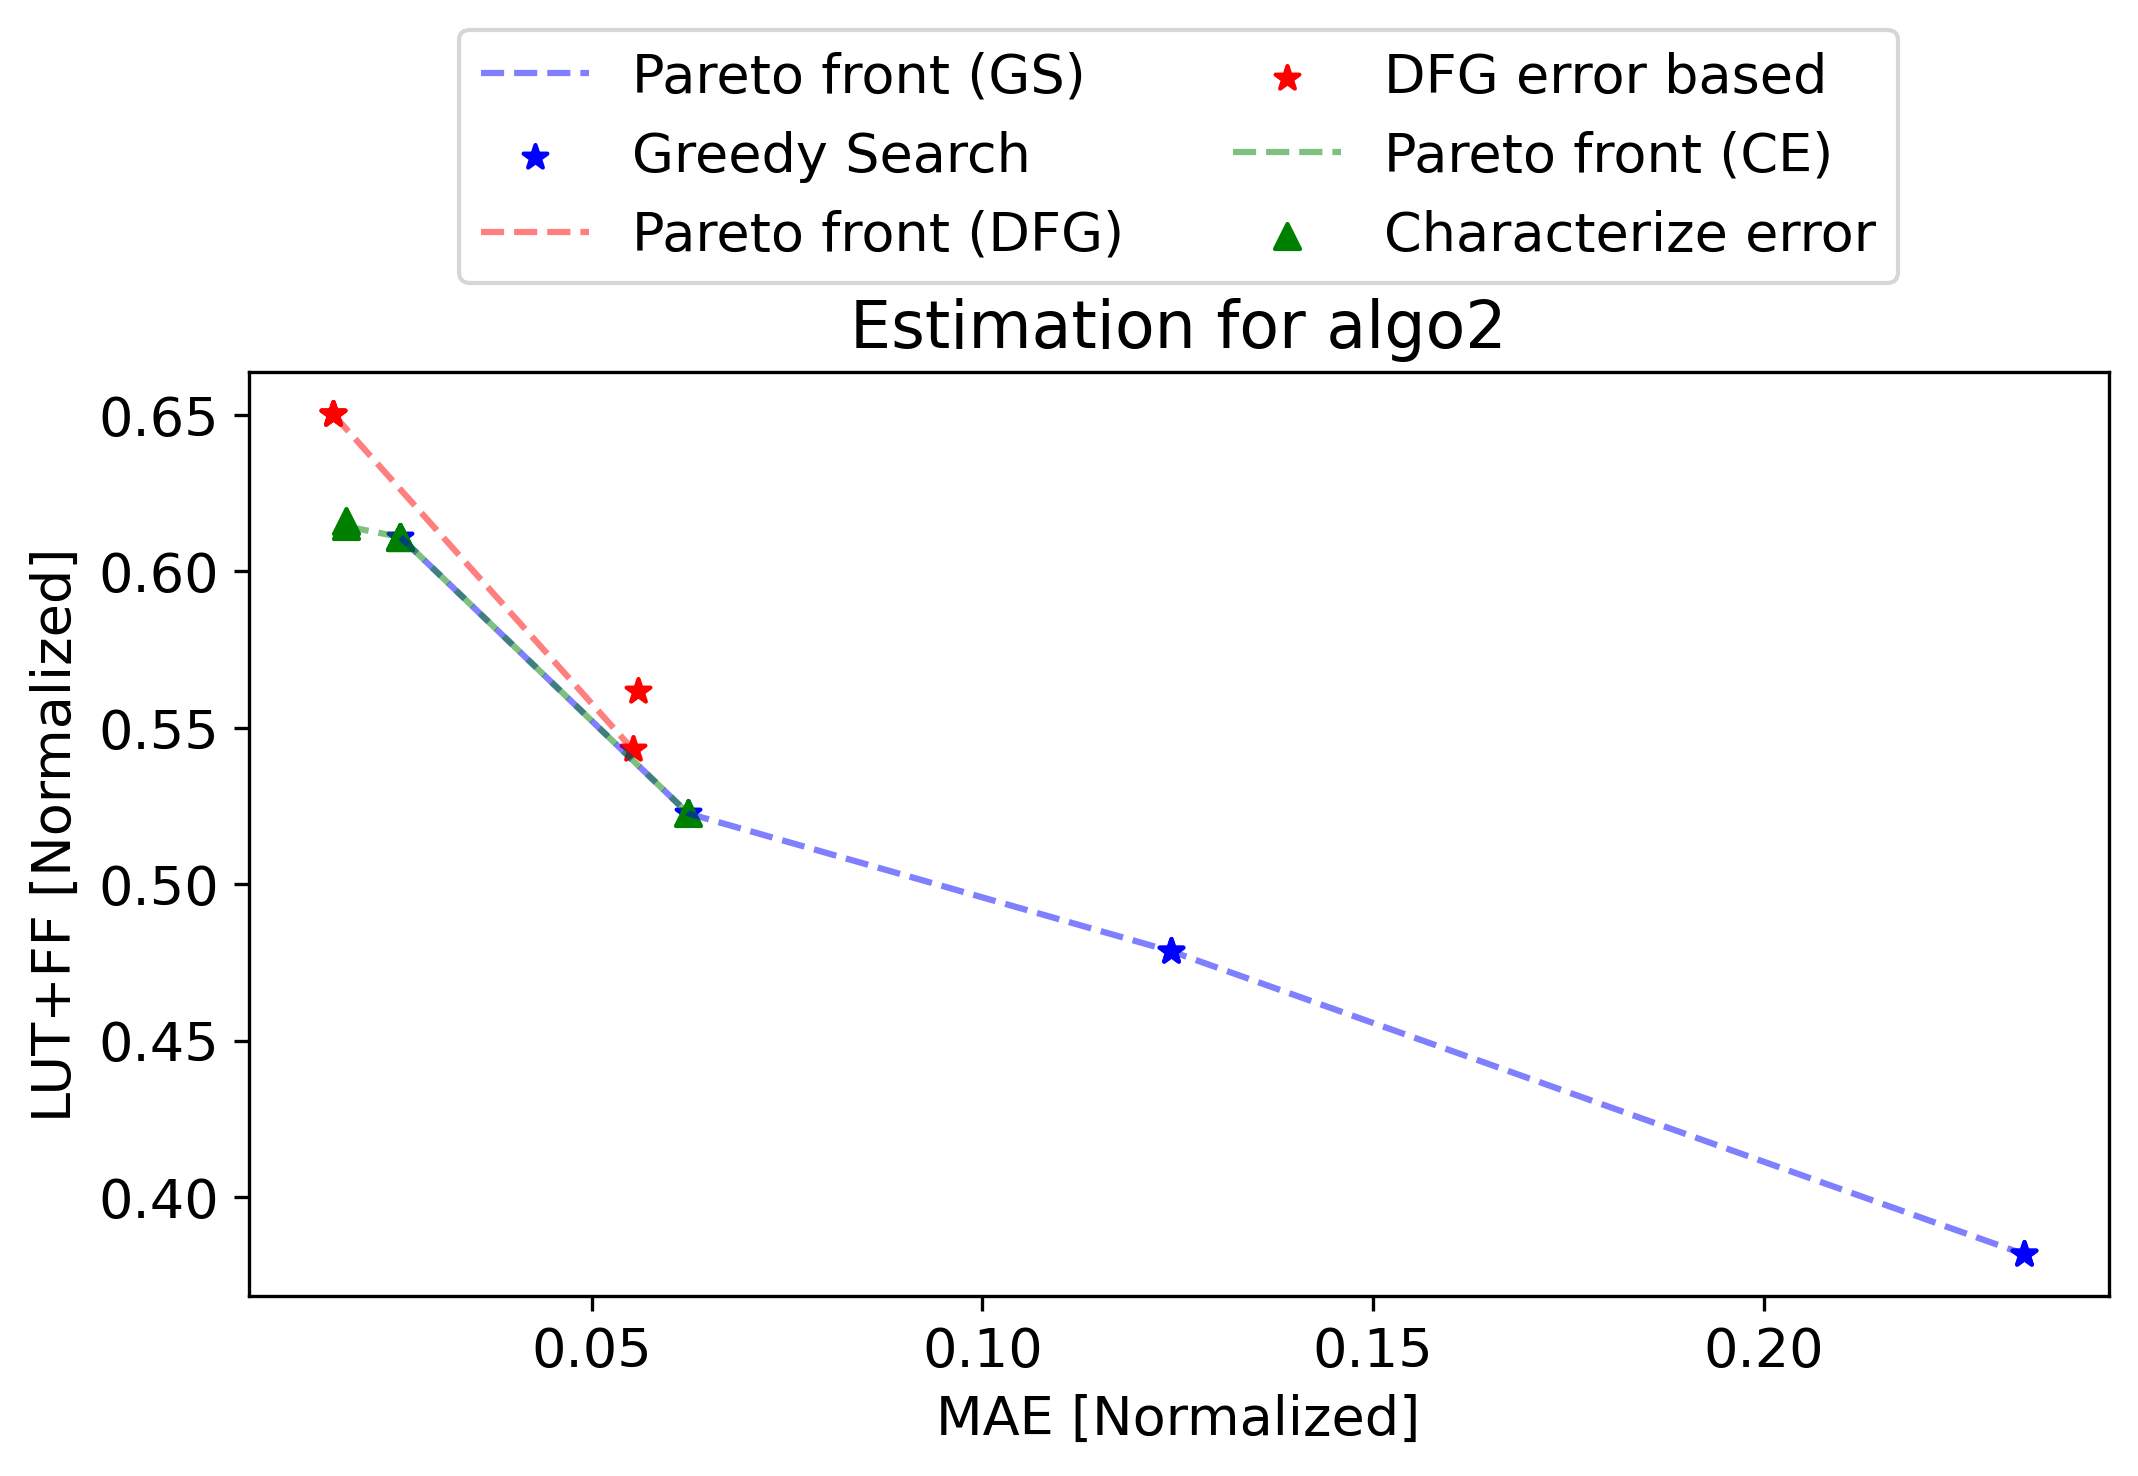

In [39]:
if dict_app['image'] == True:
    dict_app['metricerror'] = "SSIM"

path = dict_app['name']

c = pd.read_csv(path + '/dss_points.csv')
dsserror = c['error']
dssarea = c['area']

c = pd.read_csv(path + '/greed_points.csv')
error1 = c['error']
area1 = c['area']

c = pd.read_csv(path + '/dfg_points.csv')
error2 = c['error']
area2 = c['area']

c = pd.read_csv(path + '/ne_points.csv')
error3 = c['error']
area3 = c['area']

maxerror = max(max(dsserror), max(error1), max(error2), max(error3))
maxarea = max(max(dssarea), max(area1), max(area2), max(area3))

error1 /= maxerror
area1 /= maxarea

error2 /= maxerror
area2 /= maxarea

error3 /= maxerror
area3 /= maxarea

                
# Plot a scatter graph of all results
fig, ax1 = plt.subplots()
ax1.set_ylabel(dict_app['metricphysic'] + ' [Normalized]')
ax1.set_xlabel(dict_app['metricerror'] + ' [Normalized]')

p_front = pareto_frontier(list(error1), list(area1), 
                          maxX = dict_app['image'], maxY = False, start=0, final=len(area1))
ax1.plot(p_front[0], p_front[1], color='b', linestyle='--', label='Pareto front (GS)', alpha=.5)
ax1.scatter(error1, area1, color='b', marker='*', label='Greedy Search')

p_front = pareto_frontier(list(error2), list(area2), 
                          maxX = dict_app['image'], maxY = False, start=0, final=len(area2))
ax1.plot(p_front[0], p_front[1], color='r', linestyle='--', label='Pareto front (DFG)', alpha=.5)
ax1.scatter(error2, area2, color='r', marker='*', label='DFG error based')

p_front = pareto_frontier(list(error3), list(area3), 
                          maxX = dict_app['image'], maxY = False, start=0, final=len(area3))
ax1.plot(p_front[0], p_front[1], color='g', linestyle='--', label='Pareto front (CE)', alpha=.5)
ax1.scatter(error3, area3, color='g', marker='^', label='Characterize error')

   
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fancybox=True)
plt.title('Estimation for ' + dict_app['name'])
plt.savefig(dict_app['name'] + '/DSE_EST_' + dict_app['name'] + '_' + dict_app['metricerror'] + '_' + dict_app['metricphysic'] + dict_app['plotextension'], bbox_inches = 'tight')#dict_app['plotextension'], bbox_inches = 'tight')
plt.show()

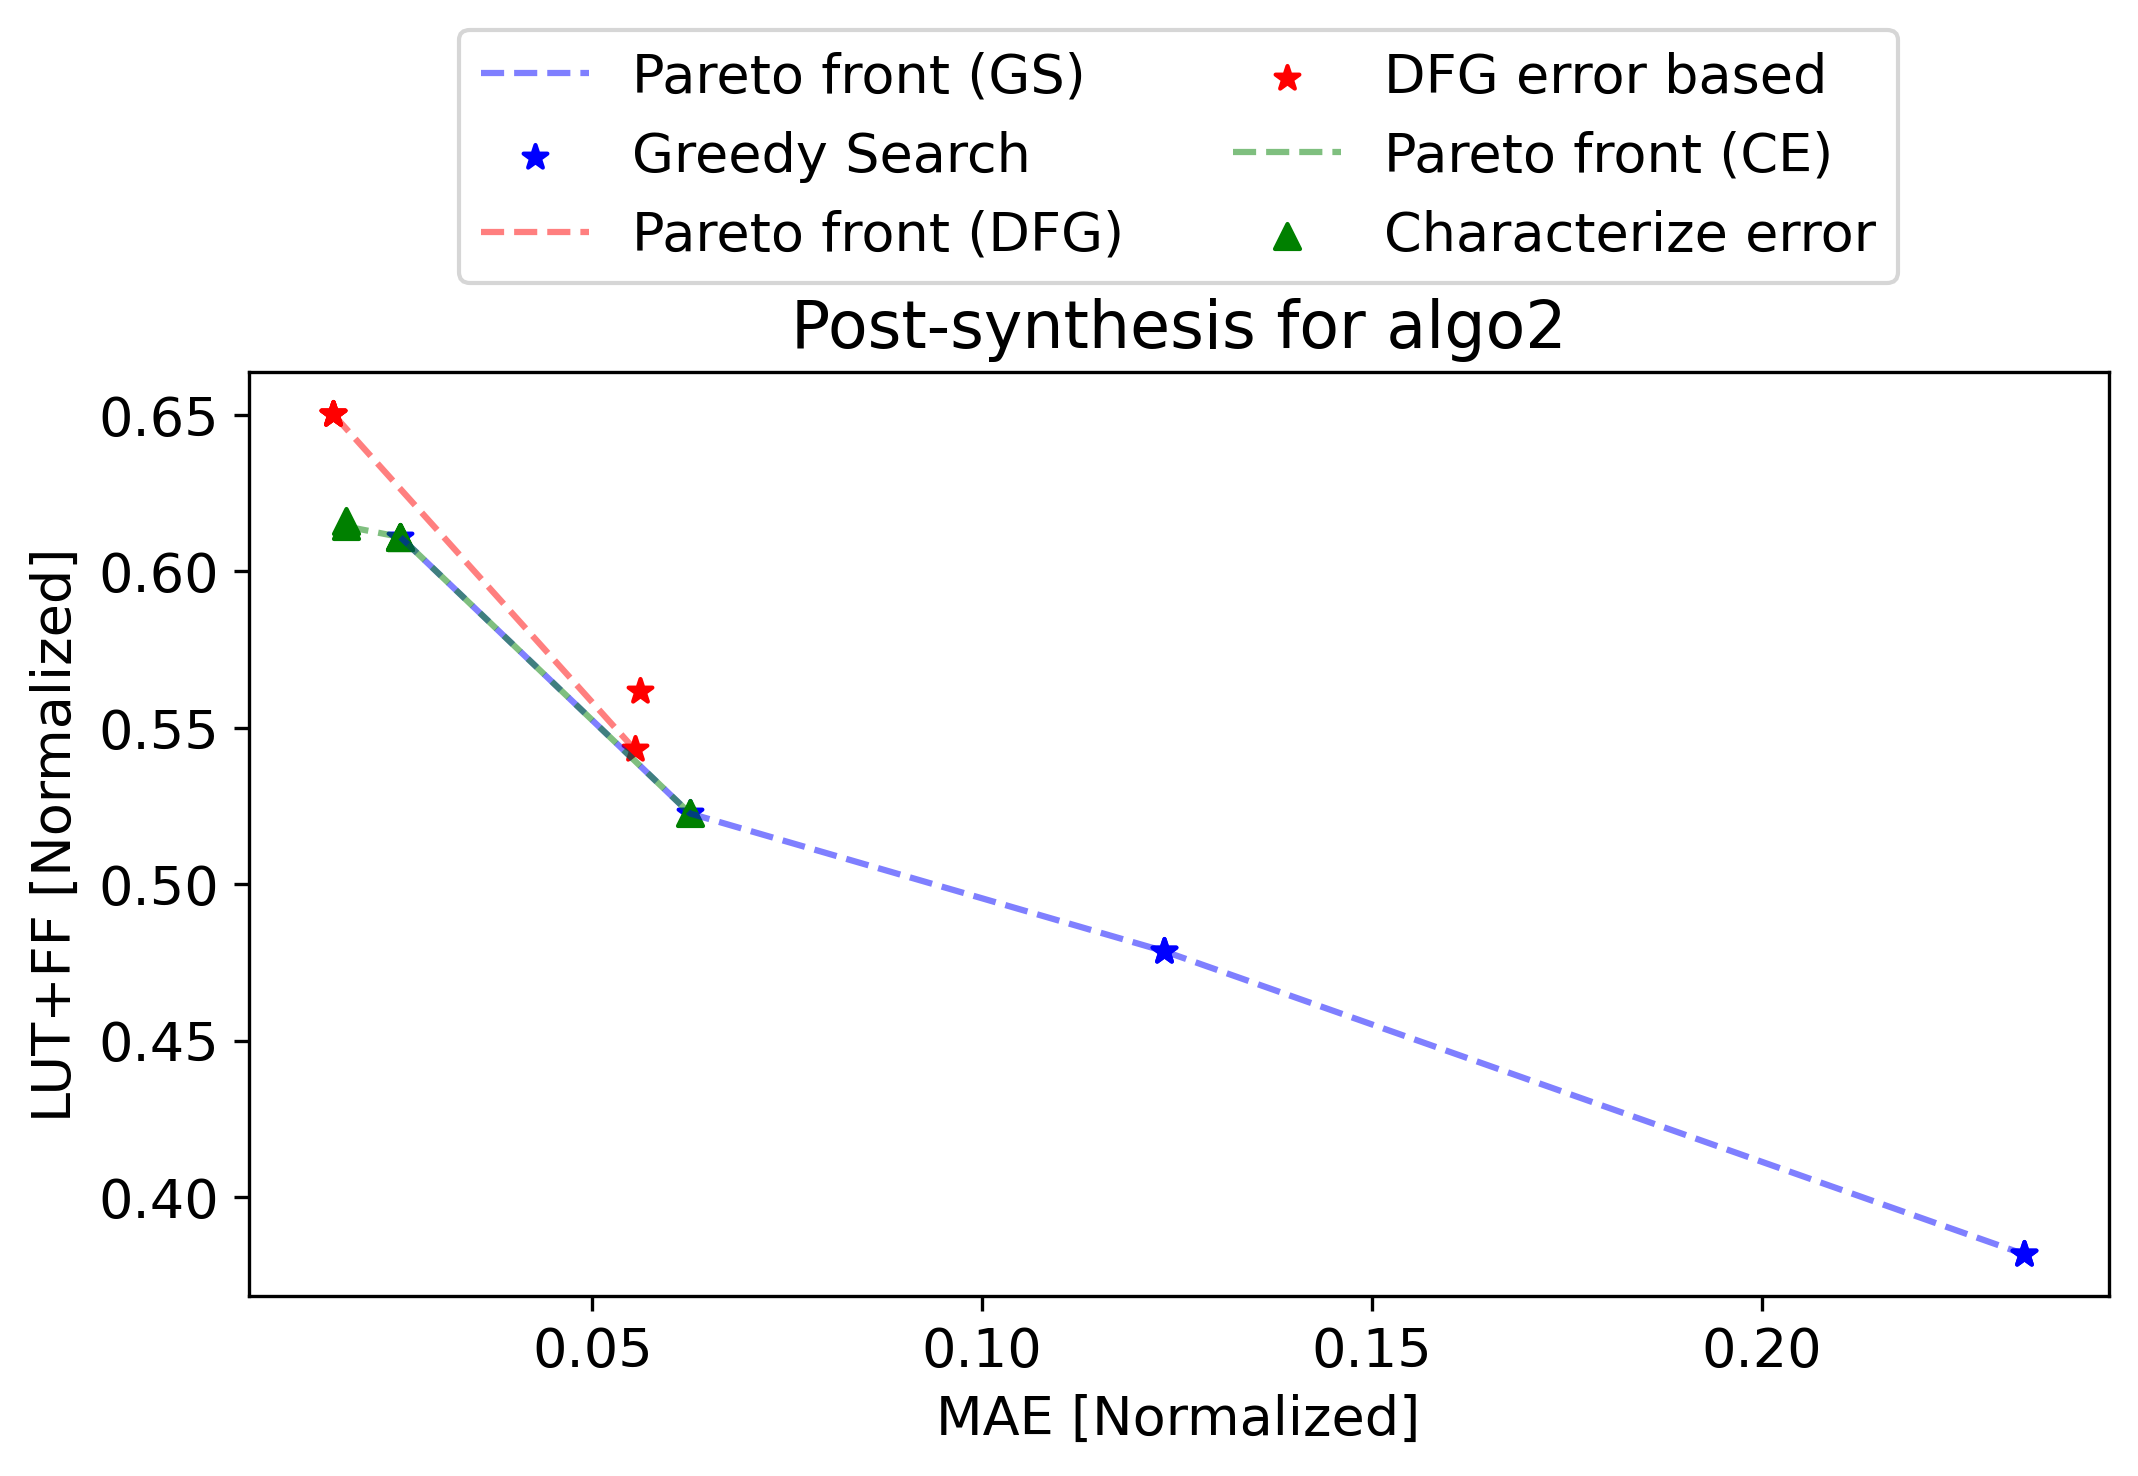

In [40]:
if dict_app['image'] == True:
    dict_app['metricerror'] = "SSIM"

path = dict_app['name']

c = pd.read_csv(path + '/dss_vitis_points.csv')
dsserror = c['error']
dssarea = c['area']

c = pd.read_csv(path + '/greed_vitis_points.csv')
error1 = c['error']
area1 = c['area']

c = pd.read_csv(path + '/dfg_vitis_points.csv')
error2 = c['error']
area2 = c['area']

c = pd.read_csv(path + '/ne_vitis_points.csv')
error3 = c['error']
area3 = c['area']

maxerror = max(max(dsserror), max(error1), max(error2), max(error3))
maxarea = max(max(dssarea), max(area1), max(area2), max(area3))

error1 /= maxerror
area1 /= maxarea

error2 /= maxerror
area2 /= maxarea

error3 /= maxerror
area3 /= maxarea

# Plot a scatter graph of all results
fig, ax1 = plt.subplots()
ax1.set_ylabel(dict_app['metricphysic'] + ' [Normalized]')
ax1.set_xlabel(dict_app['metricerror'] + ' [Normalized]')

p_front = pareto_frontier(list(error1), list(area1), 
                          maxX = dict_app['image'], maxY = False, start=0, final=len(area1))
ax1.plot(p_front[0], p_front[1], color='b', linestyle='--', label='Pareto front (GS)', alpha=.5)
ax1.scatter(error1, area1, color='b', marker='*', label='Greedy Search')

p_front = pareto_frontier(list(error2), list(area2), 
                          maxX = dict_app['image'], maxY = False, start=0, final=len(area2))
ax1.plot(p_front[0], p_front[1], color='r', linestyle='--', label='Pareto front (DFG)', alpha=.5)
ax1.scatter(error2, area2, color='r', marker='*', label='DFG error based')

p_front = pareto_frontier(list(error3), list(area3), 
                          maxX = dict_app['image'], maxY = False, start=0, final=len(area3))
ax1.plot(p_front[0], p_front[1], color='g', linestyle='--', label='Pareto front (CE)', alpha=.5)
ax1.scatter(error3, area3, color='g', marker='^', label='Characterize error')
          
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fancybox=True)
plt.title('Post-synthesis for ' + dict_app['name'])
plt.savefig(dict_app['name'] + '/DSE_PS_' + dict_app['name'] + '_' + dict_app['metricerror'] + '_' + dict_app['metricphysic'] + dict_app['plotextension'], bbox_inches = 'tight')#dict_app['plotextension'], bbox_inches = 'tight')
plt.show()

## 8.2. LUT+FF usage

(200,)
200
2JB    116.0
25S    116.0
2GE    120.0
1Y7    128.0
2JY    138.0
259    140.0
2E1    141.0
2AS    149.0
26Q    158.0
29A    158.0
RCA    162.0
294    172.0
dtype: float64


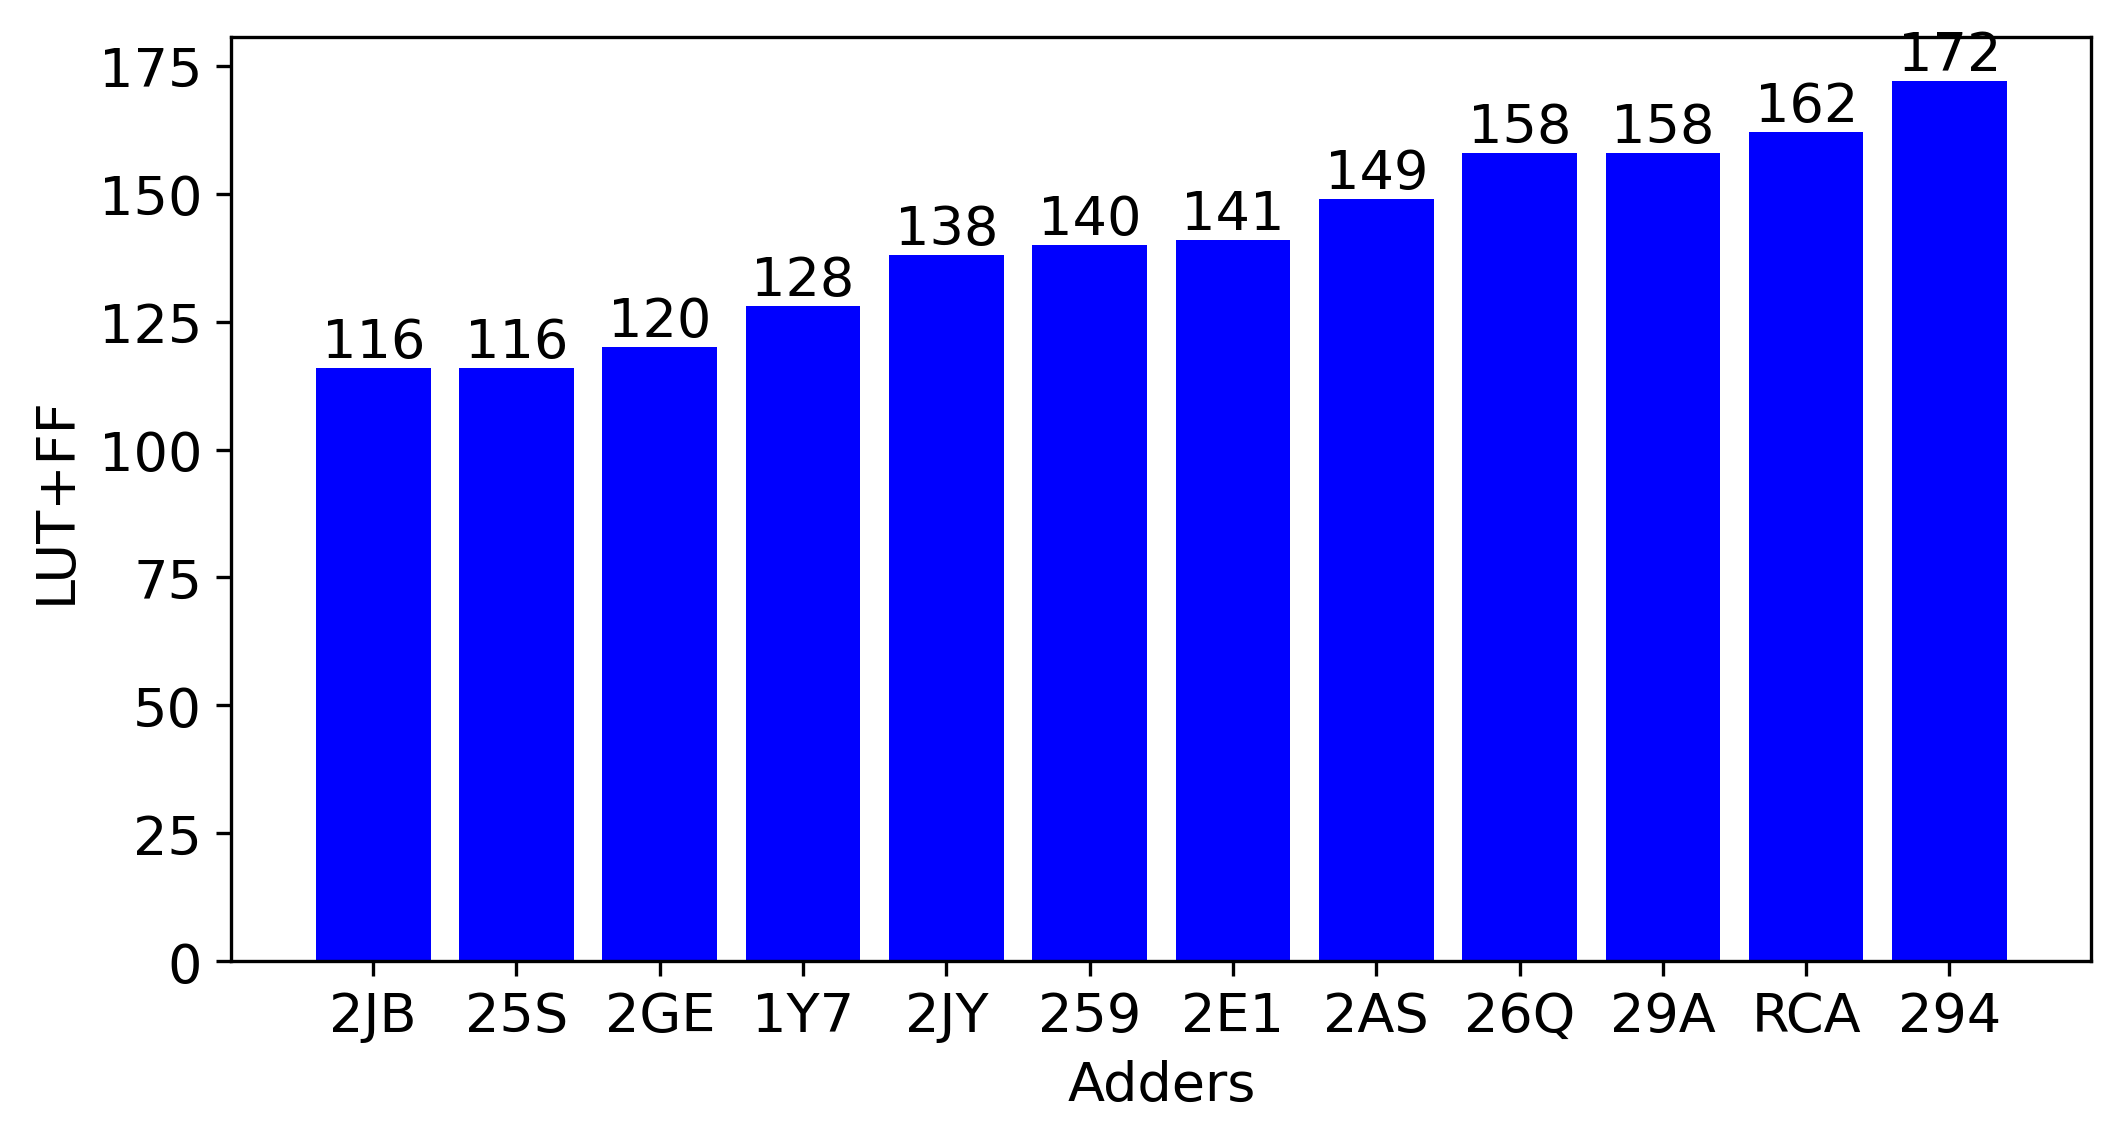

In [41]:
path = dict_app['name']

c = pd.read_csv(path + '/estimation_dss_cases.csv')

add = []
mul = []
aream = []
areaa = []

for i in range(dict_app['totalcomp']):
    if i < dict_app['totalmul']:
        mul += list(c['mul' + str(i + 1)].values)
        total = c.columns.get_loc('mul' + str(i + 1)) + 3
        aream += list(c[c.columns[total]].values)
    else:
        add += list(c['add' + str((i - dict_app['totalmul']) + 1)].values)
        total = c.columns.get_loc('add' + str((i - dict_app['totalmul']) + 1)) + 3
        areaa += list(c[c.columns[total]].values)

print(np.shape(add))
print(len(areaa))

d = dict()

for i in range(len(add)):
    if (add[i] in d):
        if not (areaa[i] in d[add[i]]):
            d[add[i]].append(areaa[i])
    else:
        d[add[i]] = [areaa[i]]
        
d = dict(sorted(d.items(), key=lambda item: item[1]))

df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

print(df.mean().round(2))

fig, ax = plt.subplots()
bars = ax.bar(df.columns, df.mean().round(2), yerr=[df.mean()-df.min(), df.max()-df.mean()], color='b')

ax.bar_label(bars)
#ax.set_ylim([110, 180])

plt.xlabel('Adders')
plt.ylabel('LUT+FF')
plt.savefig(dict_app['name'] + '/Adder_LUT+FF_usage' + dict_app['name'] + dict_app['plotextension'], bbox_inches = 'tight')
plt.show()

100
100


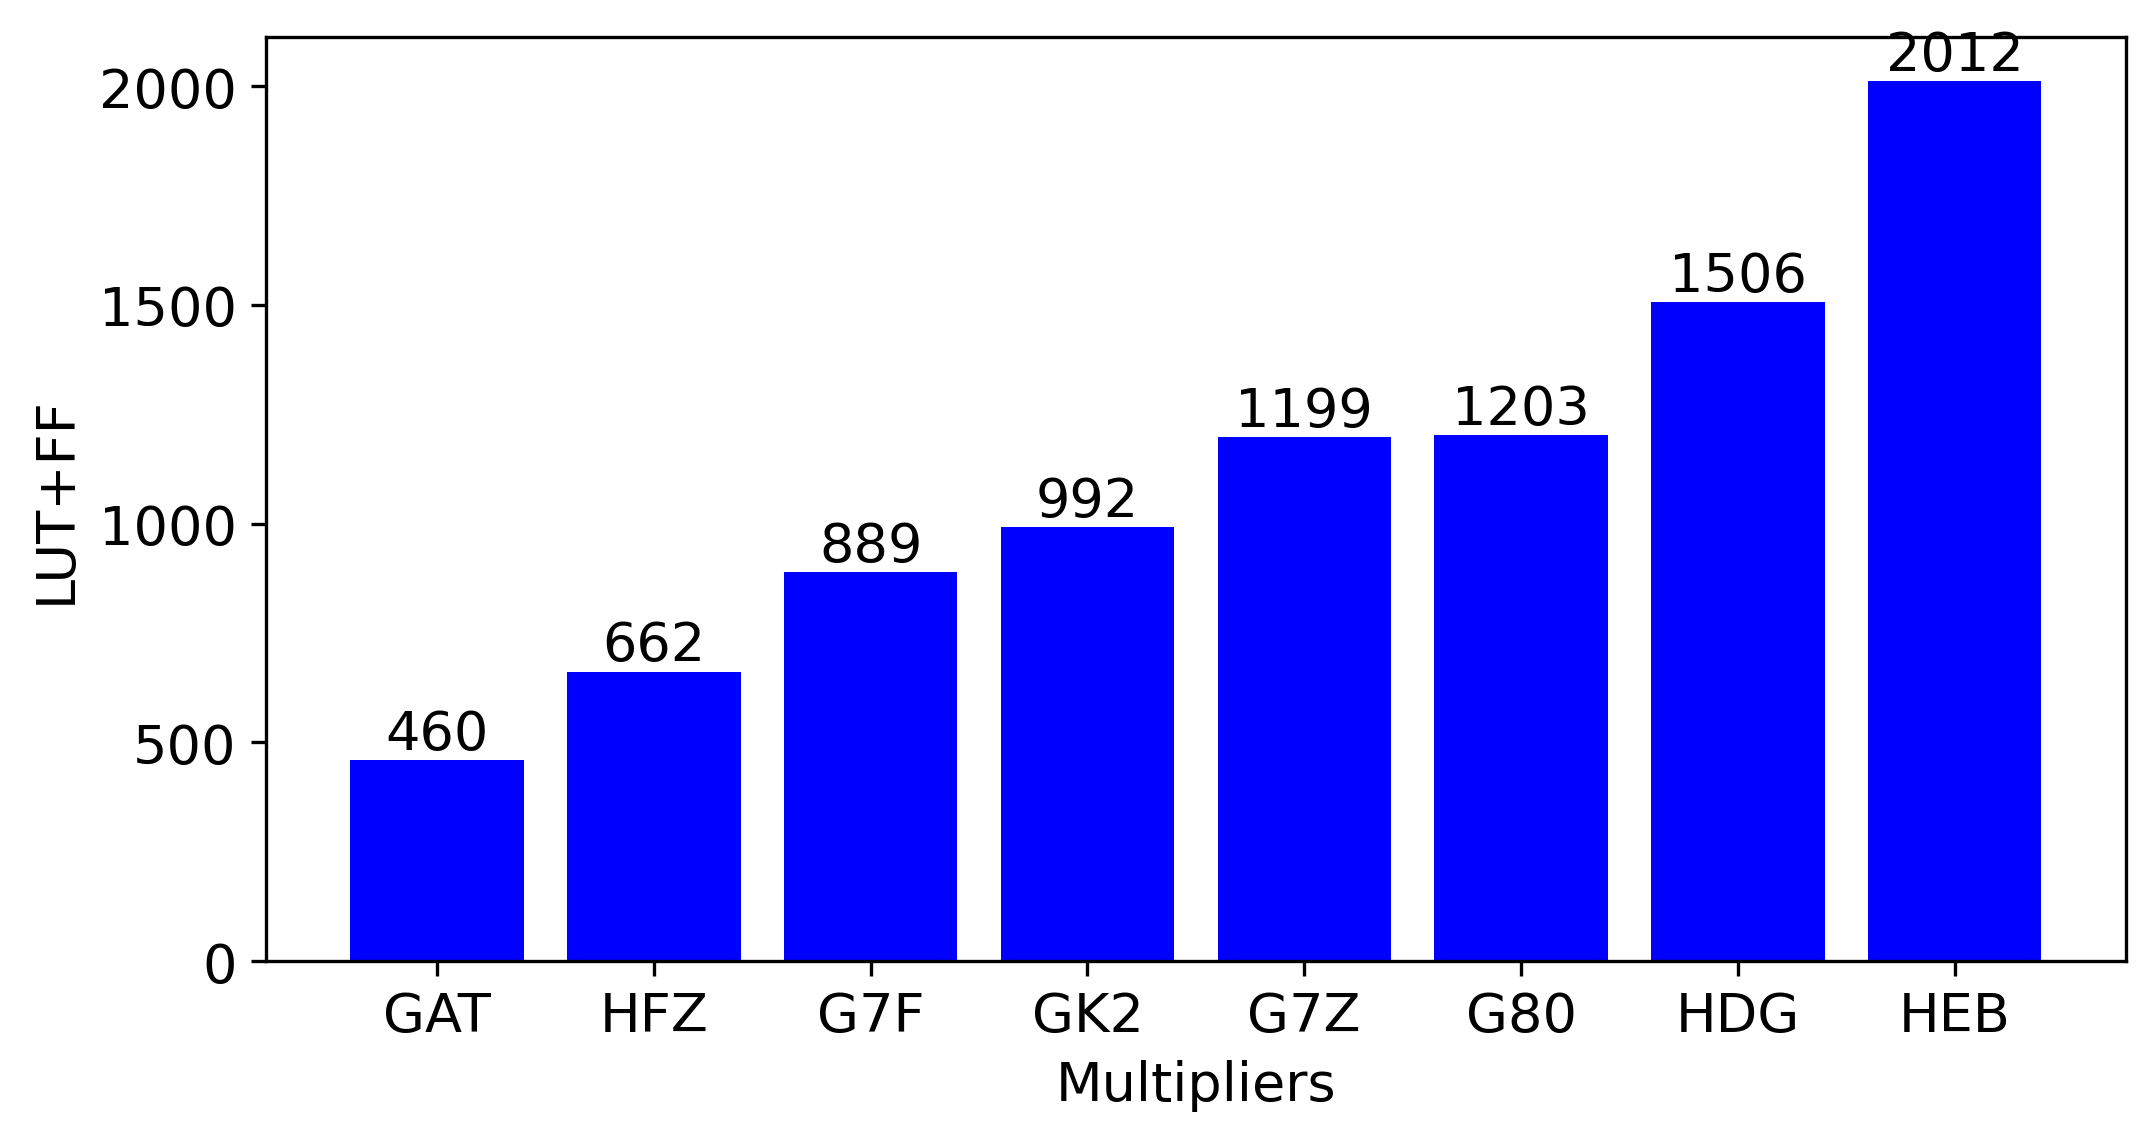

In [42]:
print(len(mul))
print(len(aream))

d = dict()

for i in range(len(mul)):
    if (mul[i] in d):
        if not (aream[i] in d[mul[i]]):
            d[mul[i]].append(aream[i])
    else:
        d[mul[i]] = [aream[i]]
        
d = dict(sorted(d.items(), key=lambda item: item[1]))

df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

fig, ax = plt.subplots()
bars = ax.bar(df.columns, df.mean().round(2), yerr=[df.mean()-df.min(), df.max()-df.mean()], color='b')

ax.bar_label(bars)
#ax.set_ylim([450, 2200])

plt.xlabel('Multipliers')
plt.ylabel('LUT+FF')
plt.savefig(dict_app['name'] + '/Multipliers_LUT+FF_usage' + dict_app['name'] + '.png', bbox_inches = 'tight')
plt.show()

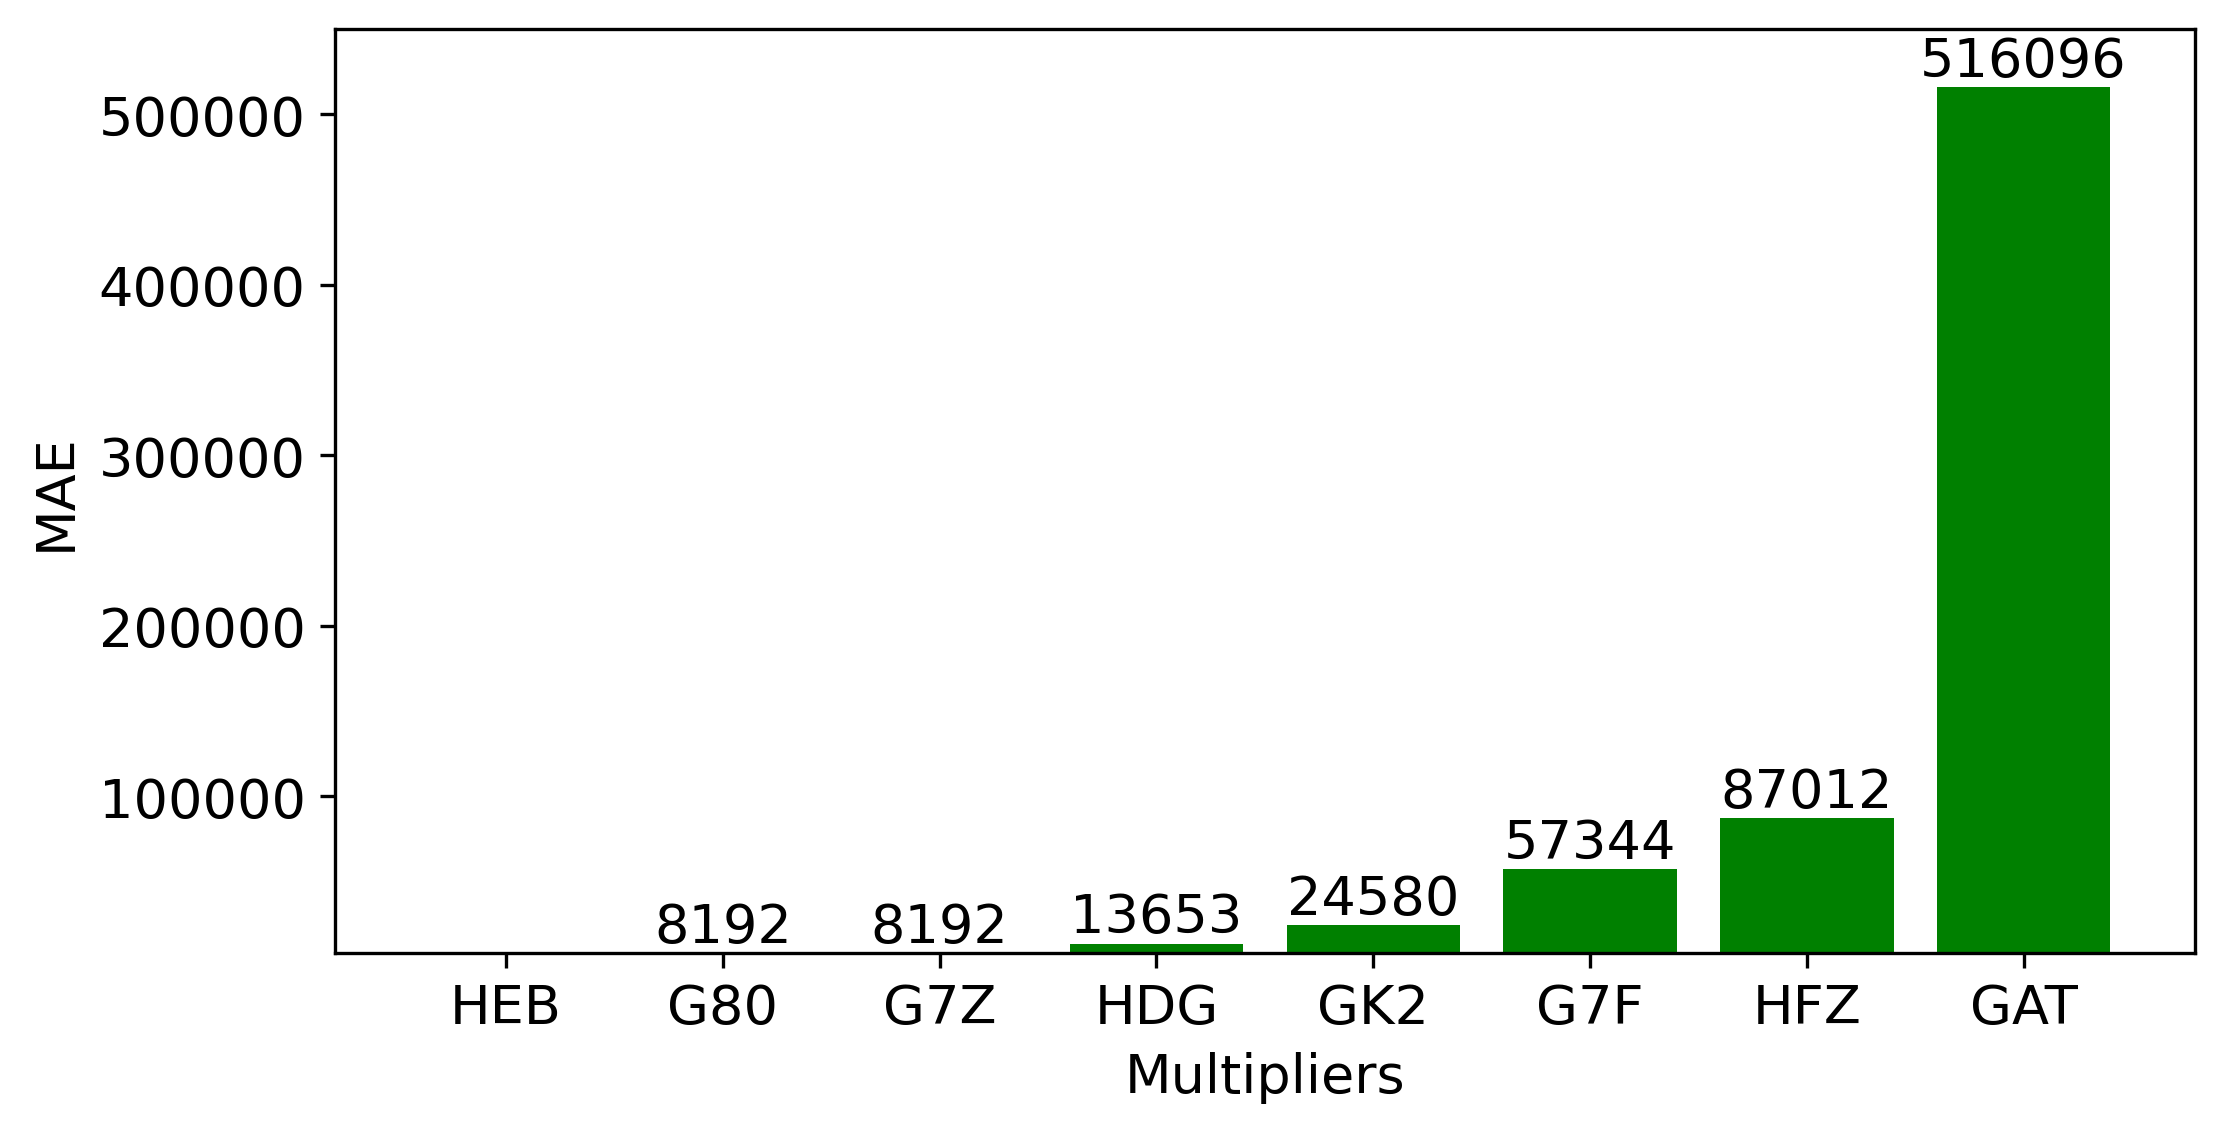

In [43]:
c3 = pd.read_csv("apps/components_rev.csv")
NAME_ADD = c3['Name'].head(8).values
ERROR_ADD = c3['MAE'].head(8).values

d2 = {NAME_ADD[i]: round(ERROR_ADD[i], 0) for i in range(len(NAME_ADD))}
d2 = dict(sorted(d2.items(), key=lambda item: item[1]))

fig, ax = plt.subplots()

bars = ax.bar(list(d2.keys()), d2.values(), color='g')

ax.bar_label(bars)
ax.set_ylim([8000, 550000])

plt.xlabel('Multipliers')
plt.ylabel('MAE')
plt.savefig('Multiplier_MAE.pdf', bbox_inches = 'tight')
plt.show()

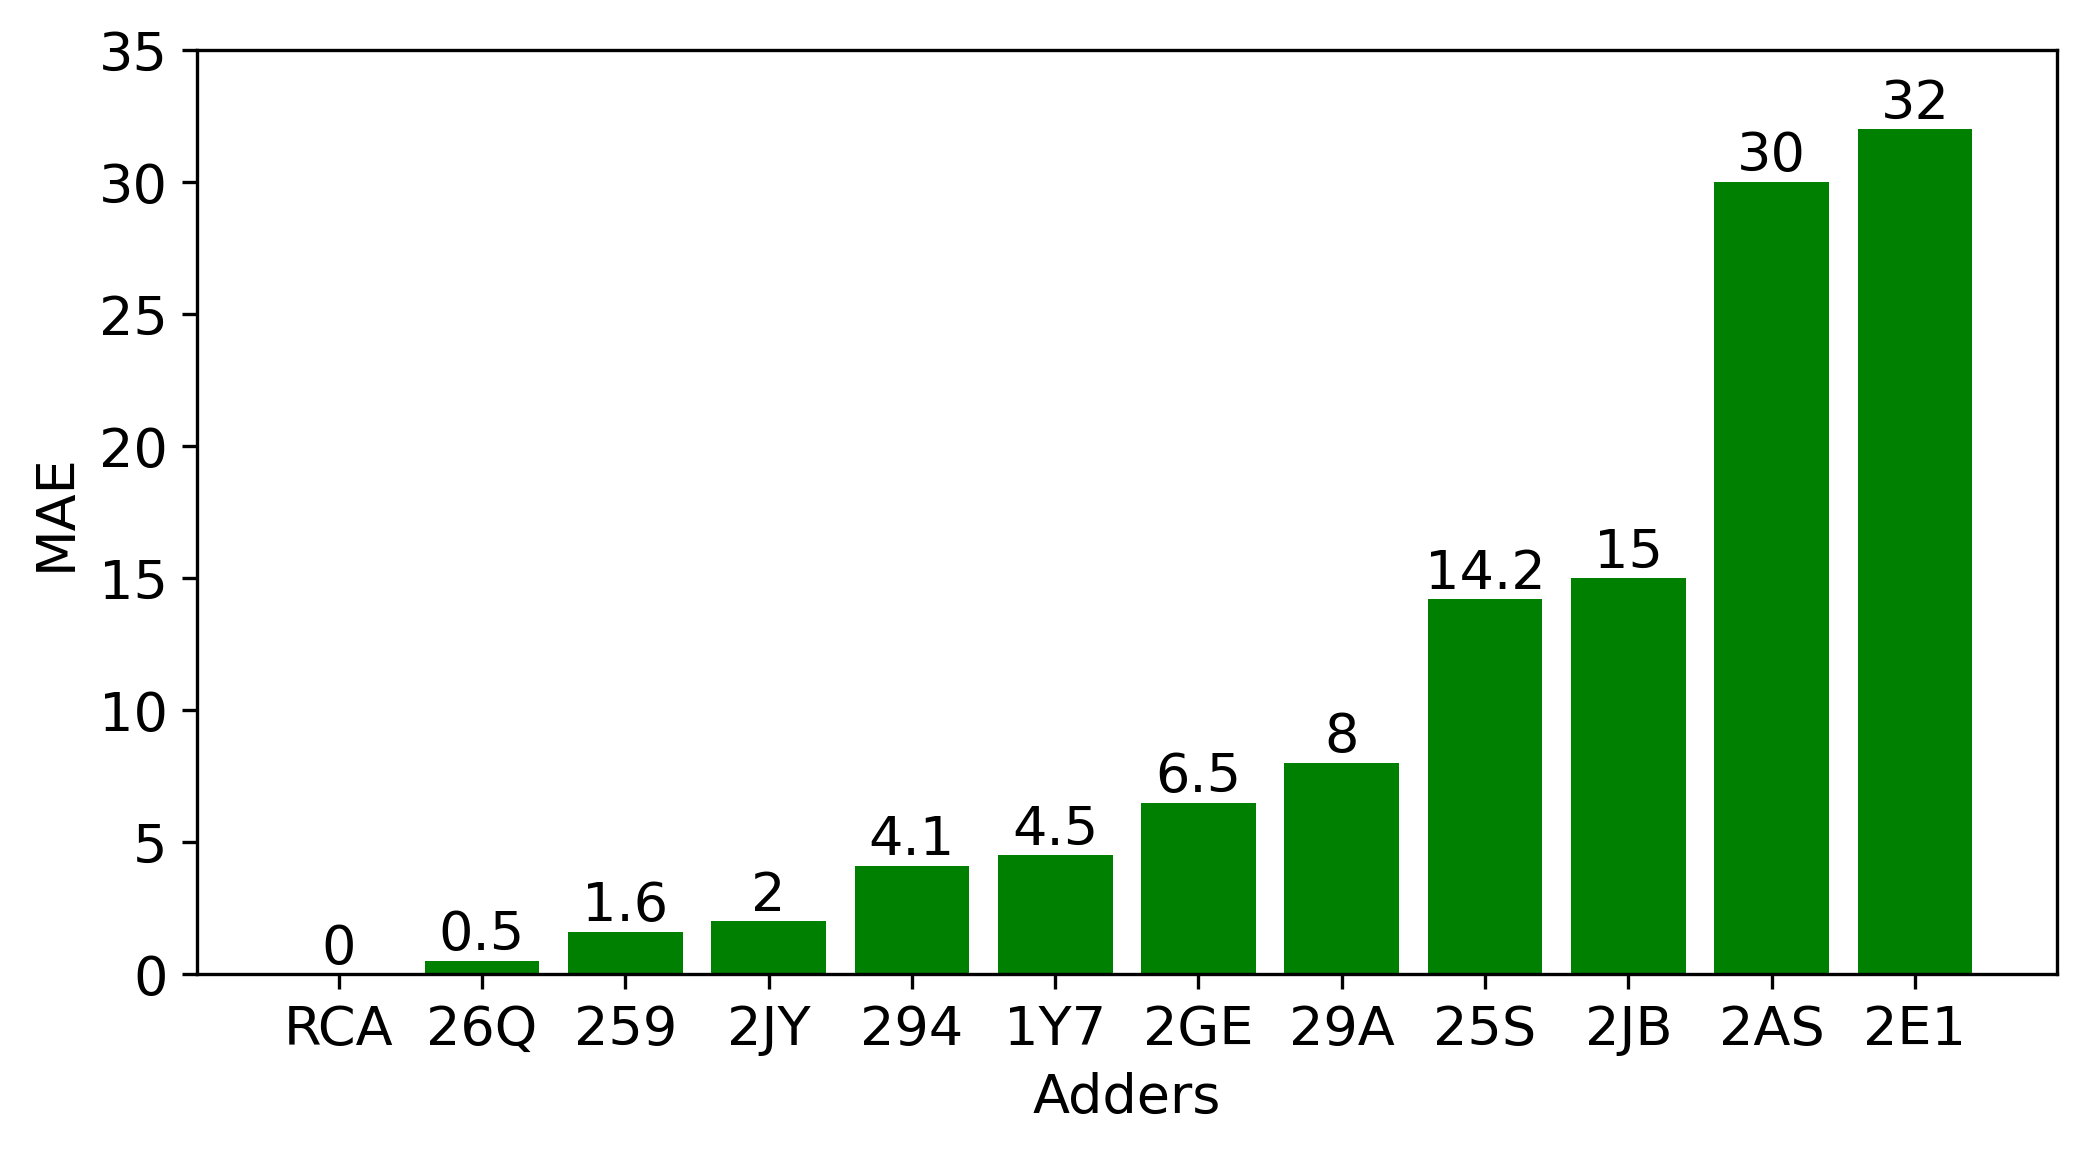

In [44]:
c3 = pd.read_csv("apps/components_rev.csv")
NAME_ADD = c3['Name'].tail(12).values
ERROR_ADD = c3['MAE'].tail(12).values

d2 = {NAME_ADD[i]: round(ERROR_ADD[i], 1) for i in range(len(NAME_ADD))}
d2 = dict(sorted(d2.items(), key=lambda item: item[1]))

fig, ax = plt.subplots()

bars = ax.bar(list(d2.keys()), d2.values(), color='g')

ax.bar_label(bars)
ax.set_ylim([0, 35])

plt.xlabel('Adders')
plt.ylabel('MAE')
plt.savefig('Adders_MAE.pdf', bbox_inches = 'tight')
plt.show()

## 7.3. Regression

RMSE: 0.00 / Spearman's R: 1.00 / R2: 1.00


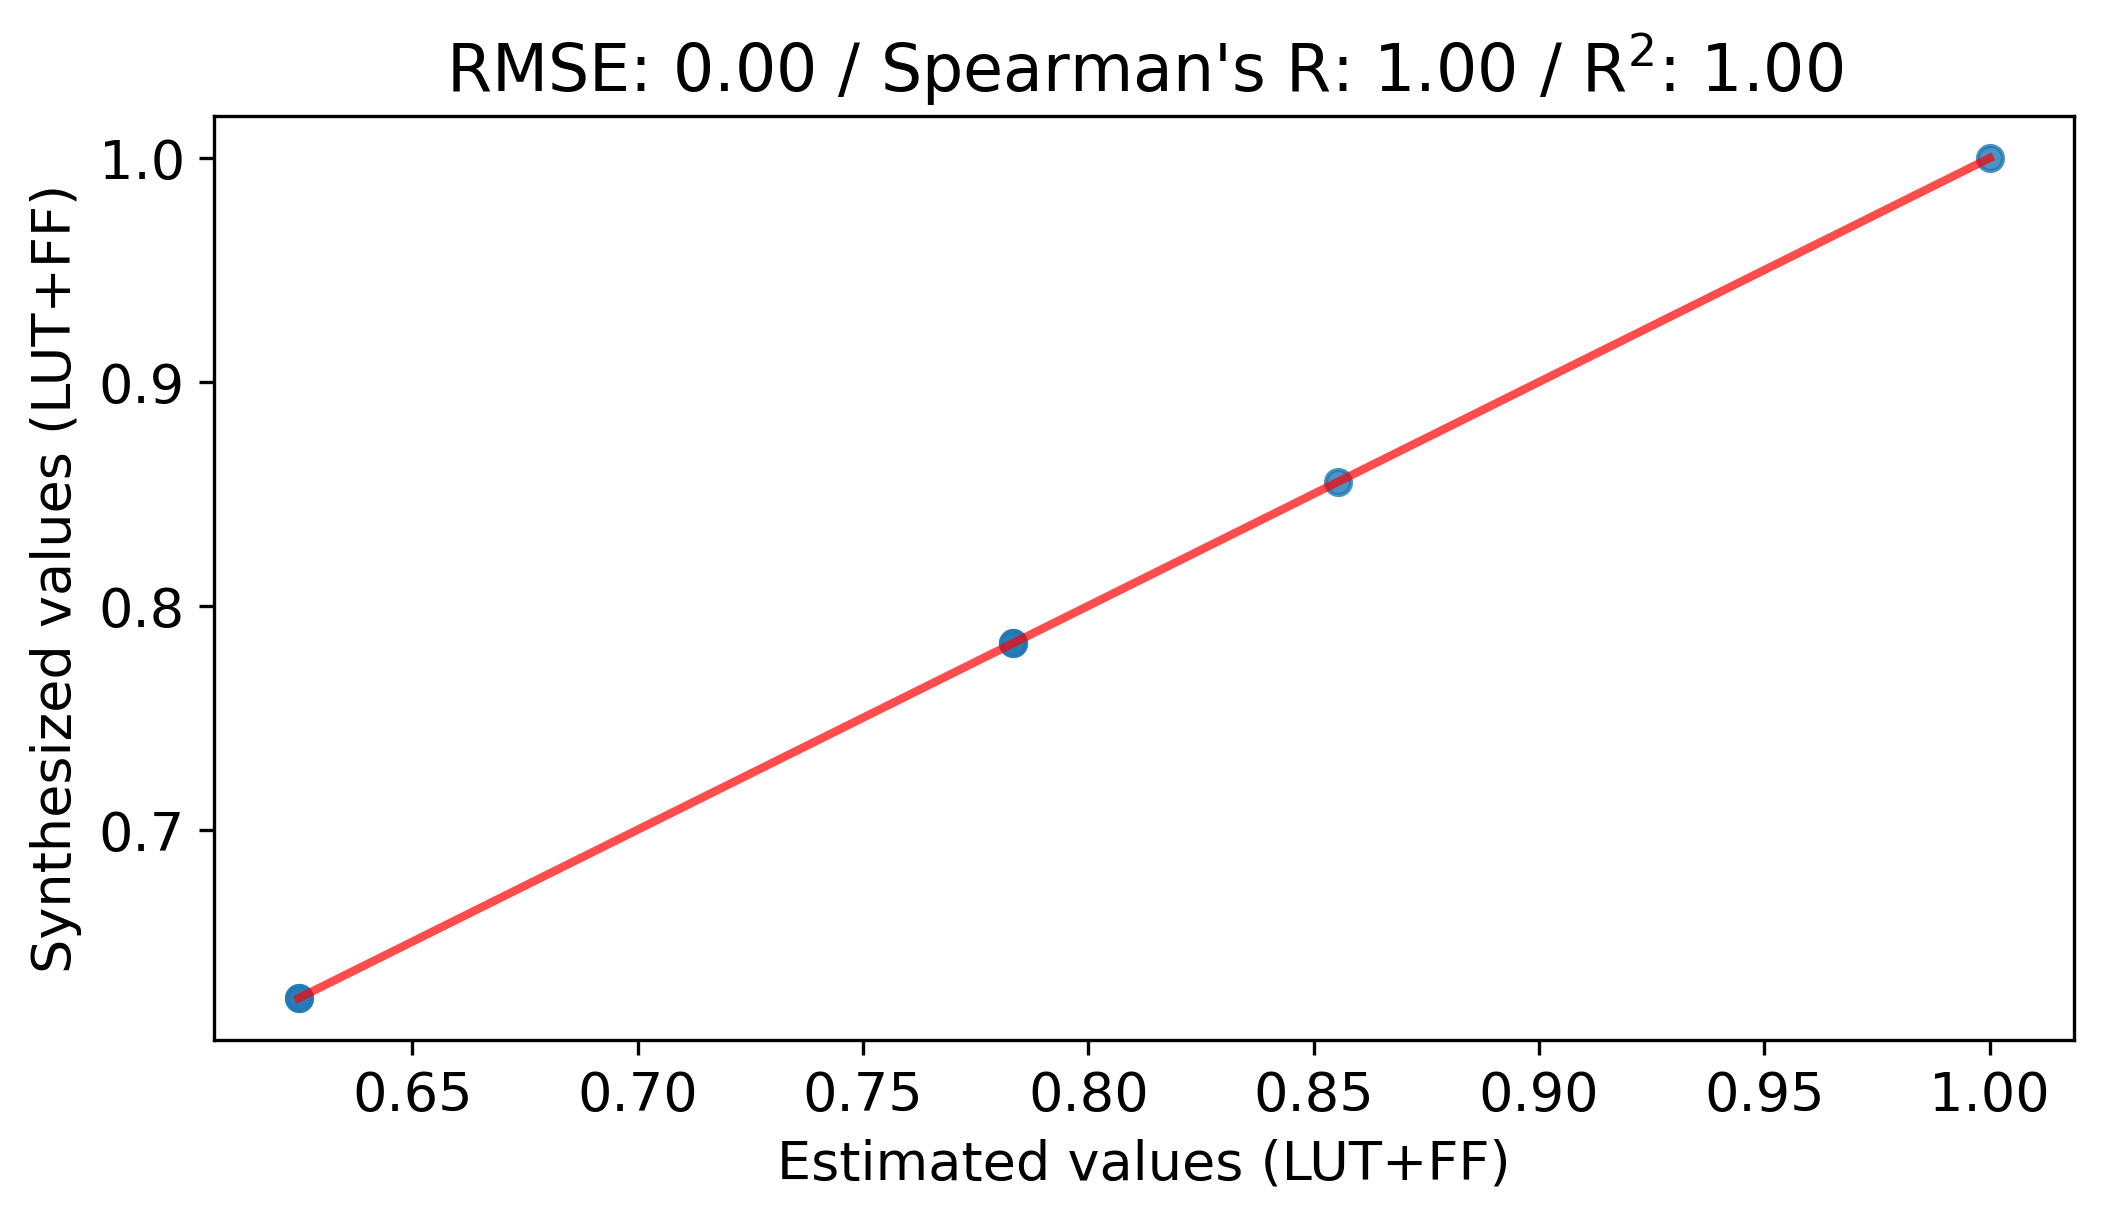

In [45]:
path = dict_app['name']

c = pd.read_csv(path + '/greed_points.csv')

area_dse = c['area']
error_dse = c['error']

c = pd.read_csv(path + '/greed_vitis_points.csv')

area_vitis = c['area']
error_vitis = c['error']

dse = area_dse
vitis = area_vitis

label_x = 'Estimated values (LUT+FF)'
label_y = 'Synthesized values (LUT+FF)'
    
df = pd.DataFrame(
    {label_x: dse,
     label_y: vitis 
    })

df[label_x] /= max(df[label_x])
df[label_y] /= max(df[label_y])

MSE = np.square(np.subtract(df[label_y], df[label_x])).mean() 
RMSE = math.sqrt(MSE)

r, p = ss.spearmanr(df[label_y], df[label_x])

from sklearn.metrics import r2_score
r2 = r2_score(df[label_y], df[label_x]) 

print(f"RMSE: {RMSE:0.2f} / Spearman's R: {r:.2f} / R2: {r2:.2f}")

sns.regplot(x=df[label_x], y=df[label_y], line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title(f"RMSE: {RMSE:0.2f} / Spearman's R: {r:.2f} / R$^2$: {r2:.2f}")
plt.savefig(dict_app['name'] + '/VITIS_vs_estimation_' + dict_app['name'] + dict_app['plotextension'], bbox_inches = 'tight')
plt.show()

## 7.4. Error over LUT+FF plus error

RMSE: 0.00 / Spearman's R: 1.00 / R2: 1.00


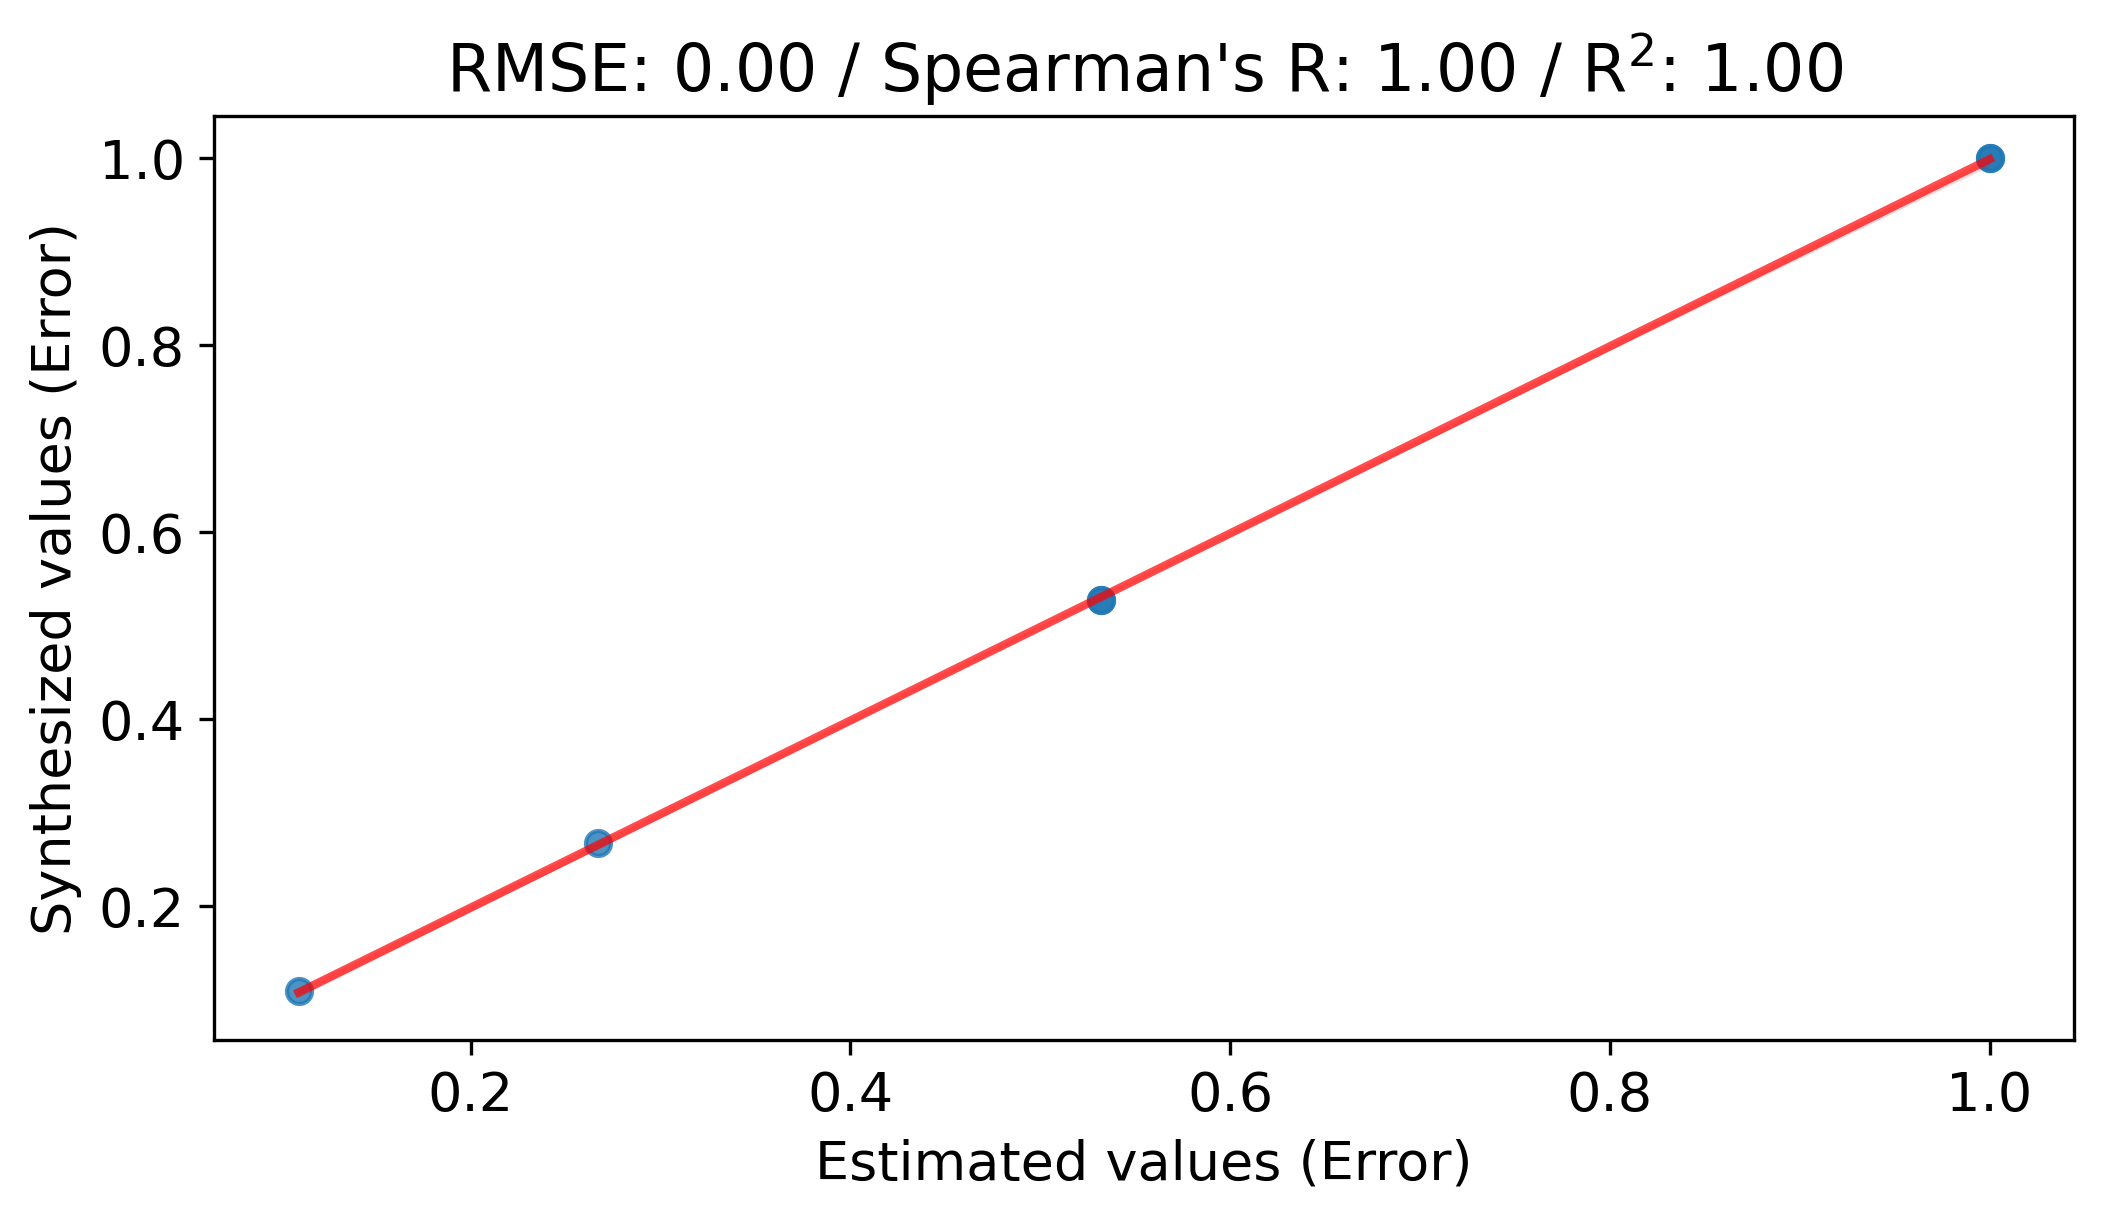

In [46]:
path = dict_app['name']

c = pd.read_csv(path + '/greed_points.csv')

area_dse = c['area']
error_dse = c['error']

c = pd.read_csv(path + '/greed_vitis_points.csv')

area_vitis = c['area']
error_vitis = c['error']

dse = error_dse
vitis = error_vitis

label_x = 'Estimated values (Error)'
label_y = 'Synthesized values (Error)'
    
df = pd.DataFrame(
    {label_x: dse,
     label_y: vitis 
    })

df[label_x] /= max(df[label_x])
df[label_y] /= max(df[label_y])

MSE = np.square(np.subtract(df[label_y], df[label_x])).mean() 
RMSE = math.sqrt(MSE)

r, p = ss.spearmanr(df[label_y], df[label_x])

from sklearn.metrics import r2_score
r2 = r2_score(df[label_y], df[label_x]) 

print(f"RMSE: {RMSE:0.2f} / Spearman's R: {r:.2f} / R2: {r2:.2f}")

sns.regplot(x=df[label_x], y=df[label_y], line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title(f"RMSE: {RMSE:0.2f} / Spearman's R: {r:.2f} / R$^2$: {r2:.2f}")
plt.savefig(dict_app['name'] + '/Error_VITIS_vs_estimation_' + dict_app['name'] + dict_app['plotextension'], bbox_inches = 'tight')
plt.show()